# Introduction
State notebook purpose here

# Set environment
Import libraries and write settings here.

In [2]:
# data handling
import pandas as pd
import numpy as np
import pingouin as pg
from itertools import combinations

# visualization
import missingno as msno
import folium
from folium.plugins import FastMarkerCluster
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from scipy.stats import norm
import scipy.stats as stats

# feature engineering
from sklearn.impute import SimpleImputer

C:\Users\sebas\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.5, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Import data

In [3]:
listings = pd.read_csv('listings_detailed.csv')

We can see that 'neihbourhood_group' is useless in the dataset, as it only contians NaN values, so we will drop this column.


Some missing values are also found in the columns concerning reviews, specifically in 'last_review' and 'reviews_per_month'

In the extended dataset for listings we found 3 columns with only NaN values: 'neighbourhood_group_cleansed', 'bathrooms' and 'calendar_updated'. Another column with mostly NaN values is 'host_neighbourhood'.

We will drop these columns and keep only columns of interest for the current analysis.

We also see that certain columns as 'price' are the wrong data type. We will force the conversion to the correct data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5289 entries, 0 to 5288
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5289 non-null   int64  
 1   listing_url                                   5289 non-null   object 
 2   scrape_id                                     5289 non-null   int64  
 3   last_scraped                                  5289 non-null   object 
 4   name                                          5289 non-null   object 
 5   description                                   5285 non-null   object 
 6   neighborhood_overview                         2941 non-null   object 
 7   picture_url                                   5289 non-null   object 
 8   host_id                                       5289 non-null   int64  
 9   host_url                                      5289 non-null   o

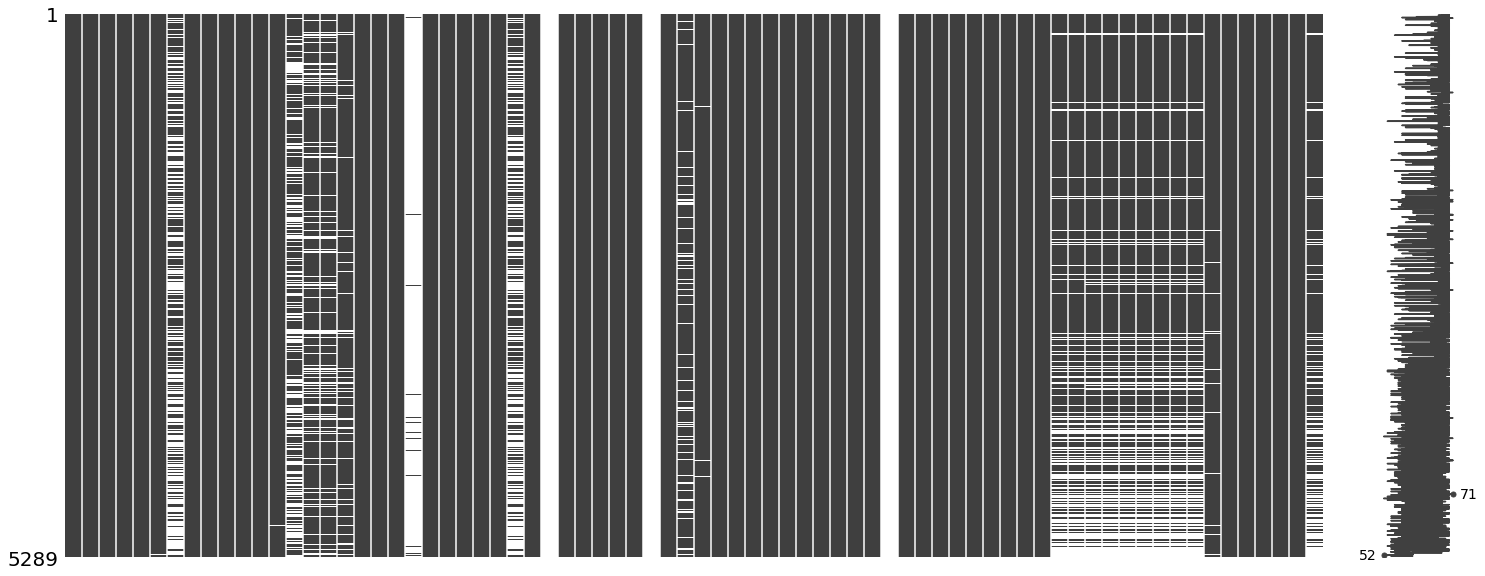

In [4]:
msno.matrix(listings)

# price contains string ($) so we will remove the dollar sign and force the conversion
listings['price'] = listings['price'].str.slice(start=1)

# force conversion
listings['price'] = listings['price'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
listings.info()

We are going to do something similar with 'bathrooms_text'. We are going to create a new feature called 'bathroom_type' that will have a value 'shared' if the bathroom is shared with other people, otherwise 'no shared'. We will convert the 'bathrooms_text' column into an ordinal one.

In [5]:
# masks
shared = listings['bathrooms_text'].str.contains('shared')
half_bath = listings['bathrooms_text'].str.contains('half-bath')

# apply masks for shared or not shared bathroom
listings['bathroom_type'] = 'no shared'
listings['bathrooms'] = ''
listings.loc[shared, 'bathroom_type'] = 'shared'
# extract numeric values for baths
listings['bathrooms'] = listings['bathrooms_text'].str.extract('(\d+(?:\.\d+)?)', expand=False)
# now get half-bath
listings.loc[half_bath, 'bathrooms'] = 0.5
# convert 'bathrooms' into numeric type
listings['bathrooms'] = listings['bathrooms'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
# drop 'bathrooms_text'
listings.drop(columns='bathrooms_text', inplace=True)

We are going to build our model to predict price based only on accomodation characteristics (physically and also on the website [rating, review scores, etc.]. Based on this, we will drop variables that encode information about the host for example.

We see that we have quite a few columns containing information about minimum and maximum nights. Let's explore these to check if they contain useful information.

We can see that some of the columns contains the same information as 'minimum_nights' and 'maximum_nights'. We will keep it simple and we will only keep these two columns. 

We will drop 'neighbourhood' columns except 'neighbourhood_cleansed' as this last columns contains the neighbourhoods of Málaga province. Also, those columns contains a lot of missing values.

We will also drop 'has availability' column at it only contains True values.

In [6]:
keep_cols = ['host_id', 'id', 'minimum_nights', 'maximum_nights', 'host_is_superhost']
host_cols = [col for col in listings.columns if 'host' in col if col not in keep_cols]
night_cols = [col for col in listings.columns if 'nights' in col if col not in keep_cols]
other_cols = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 
              'picture_url', 'availability_30', 'availability_60', 'availability_90', 
              'first_review', 'last_review', 'license', 'number_of_reviews_ltm',
              'number_of_reviews_l30d', 'calendar_last_scraped', 'neighborhood_overview',
              'neighbourhood', 'has_availability', 'amenities']

Finally, let's drop empty columns.

In [7]:
mask_empty_cols = listings.isnull().sum() == len(listings)
empty_cols = listings.columns[mask_empty_cols].to_list()

## Drop columns

In [8]:
cols_drop = host_cols + other_cols + night_cols + empty_cols

listings.drop(columns=cols_drop, inplace=True)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5289 entries, 0 to 5288
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           5289 non-null   int64  
 1   host_id                      5289 non-null   int64  
 2   host_is_superhost            5289 non-null   object 
 3   neighbourhood_cleansed       5289 non-null   object 
 4   latitude                     5289 non-null   float64
 5   longitude                    5289 non-null   float64
 6   property_type                5289 non-null   object 
 7   room_type                    5289 non-null   object 
 8   accommodates                 5289 non-null   int64  
 9   bathrooms                    5287 non-null   float64
 10  bedrooms                     4853 non-null   float64
 11  beds                         5266 non-null   float64
 12  price                        5271 non-null   float64
 13  minimum_nights    

## Impute data

We also see that we have some missing values in reviews (1098 for each type of review), bedrooms (436), beds (23) and price (18), so we will impute these missing data with the mean.

In [9]:
series = listings.isnull().sum().sort_values(ascending=False)
list_miss = series[series > 0].index.to_list()
list_miss

['review_scores_accuracy',
 'review_scores_rating',
 'review_scores_value',
 'review_scores_location',
 'review_scores_communication',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'reviews_per_month',
 'bedrooms',
 'beds',
 'price',
 'bathrooms']

We are going to transform out DataFrame into a Numpy array to impute the data.

In [10]:
to_impute = listings[list_miss].to_numpy()

We will apply the imputer to our data. This imputation will take place only for bedrooms, beds and price, and will be imputed with the mean. Afterwards, we will check that non-missing values are left in the DataFrame.

In [11]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(to_impute)
imputed = pd.DataFrame(data=imp.transform(to_impute), columns=listings[list_miss].columns)
imputed.isnull().sum()

review_scores_accuracy         0
review_scores_rating           0
review_scores_value            0
review_scores_location         0
review_scores_communication    0
review_scores_checkin          0
review_scores_cleanliness      0
reviews_per_month              0
bedrooms                       0
beds                           0
price                          0
bathrooms                      0
dtype: int64

Check that we do not have any missing value

In [12]:
listings = pd.concat([listings.drop(columns=list_miss), imputed], axis=1)
listings.isnull().sum()

id                             0
host_id                        0
host_is_superhost              0
neighbourhood_cleansed         0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
minimum_nights                 0
maximum_nights                 0
availability_365               0
number_of_reviews              0
instant_bookable               0
bathroom_type                  0
review_scores_accuracy         0
review_scores_rating           0
review_scores_value            0
review_scores_location         0
review_scores_communication    0
review_scores_checkin          0
review_scores_cleanliness      0
reviews_per_month              0
bedrooms                       0
beds                           0
price                          0
bathrooms                      0
dtype: int64

## Define X and y

In [13]:
X = listings.drop(columns='price')
y = listings['price']

# Exploratory data analysis (EDA)

Let's print the head of 'listings' to see what king of information each column is offering us.

In [14]:
display(X.head())

,id,host_id,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,minimum_nights,...,review_scores_rating,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,reviews_per_month,bedrooms,beds,bathrooms
0,96033,510467,t,Este,36.72031,-4.35627,Entire apartment,Entire home/apt,3,5,...,90.0,9.0,9.0,10.0,10.0,9.0,1.04,2.0,2.0,1.0
1,155696,697056,f,Centro,36.72723,-4.40720,Entire condominium,Entire home/apt,5,3,...,91.0,9.0,9.0,10.0,10.0,9.0,0.16,3.0,5.0,2.5
2,166473,793360,t,Este,36.71934,-4.35942,Private room in apartment,Private room,3,5,...,94.0,9.0,10.0,10.0,9.0,9.0,0.62,1.0,0.0,2.0
3,212845,617998,f,Este,36.72606,-4.36541,Shared room in apartment,Shared room,2,2,...,95.0,9.0,9.0,10.0,10.0,10.0,0.34,1.0,2.0,1.5
4,229511,1198693,f,Este,36.79087,-4.38198,Entire house,Entire home/apt,12,5,...,100.0,10.0,8.0,10.0,10.0,9.0,0.08,4.0,10.0,2.0


Is it possible that each Airbnb room/flat have a different 'id'? or maybe this would be addressed by 'host_id'? Let's explore this!

We can see that 'id' has the same length as the DataFrame. Therefore, 'Id' is giving us a different id for each Airbnb accomodation. On the other hand, Host id has a unique id for each host, so if a host has 3 accomodations offered in the platform, they will be registered under the same host id.

We can also see that the three hosts in the top 3 with the highest number of Airbnb accomodations have 218, 66 and 65 places offered respectively!

In [15]:
print('Size of unique Id details: \n' + str(len(X['id'].value_counts())))
print('\nSize of unique host id details: \n' + str(len(X['host_id'].value_counts())))
print('\nHosts with the highest number of Airbnb accomodations offered: \n')
no_accomodations_per_host = X.groupby(['host_id']).agg({'id': 'count'}).reset_index(drop=False)
no_accomodations_per_host.rename(columns={'id': 'n_accomodations'}, inplace=True)
display(no_accomodations_per_host.sort_values(by='n_accomodations', ascending=False).head())

Size of unique Id details: 
5289

Size of unique host id details: 
2327

Hosts with the highest number of Airbnb accomodations offered: 



,host_id,n_accomodations
1031,80225433,218
138,5890675,66
1245,115528688,65
1126,94173177,61
1320,126429738,56


## Map

First, let's create a map to visualize the number of hosts in the city of Málaga.

Let's extract the information of the location of each Airbnb host. In the listings DataFrame we have one column for the latitude and another for the longitude. We will zip both to use it in the interactive map.

We will locate the map in the following latitude and longitude, following data found in the web concerning the location of Málaga: (36.72016, -4.42034)

We can see in the map that most of the Airbnb hosts are located in the city of Malaga, while some place are found in the surrounding areas.

In [16]:
latitude = X['latitude'].tolist()
longitude = X['longitude'].tolist()
location_info = list(zip(latitude, longitude))

map_malaga = folium.Map(location=[36.72016, -4.42034],
                        zoom_start=12,
                        tiles='cartodbpositron')
FastMarkerCluster(location_info).add_to(map_malaga)
map_malaga

## Number of accomodations per neighbourhood

Let's explore then the number of accomodations offered by neighbourhood in Málaga.

We can see that Málaga Centro has the highest number of accomodations with 3591! This could be expected, as all tourist who do not know the city would like to have an accomodation in the city centre. This neighbourhood is followed by Este with 578, an area with well-known beaches. Finally, Carretera de Cádiz with 449 is another neighbourhood next to the coast, but away from the touristic area.

,neighbourhood_cleansed,id
0,Centro,3591
1,Este,578
2,Carretera de Cadiz,449
3,Cruz De Humilladero,229
4,Bailen-Miraflores,135
5,Churriana,104
6,Teatinos-Universidad,76
7,Ciudad Jardin,46
8,Palma-Palmilla,35
9,Puerto de la Torre,24


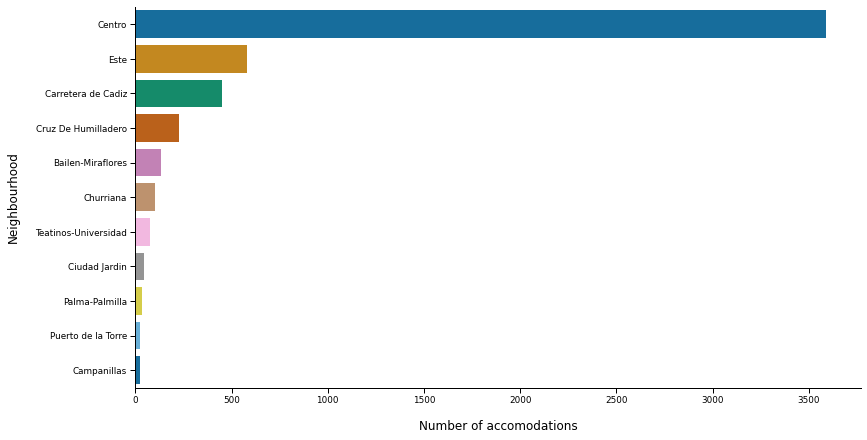

In [17]:
accomodations_per_neighbourhood = X.groupby(['neighbourhood_cleansed'])['id'].count().sort_values(ascending=False).reset_index()
display(accomodations_per_neighbourhood)

# plot
sns.set_context('paper')
ax, fig = plt.subplots(figsize=(13, 7))
sns.barplot(x='id', y='neighbourhood_cleansed', data=accomodations_per_neighbourhood, orient='h', palette='colorblind')
plt.xlabel(xlabel='Number of accomodations', labelpad=15, fontsize=12)
plt.ylabel(ylabel='Neighbourhood', labelpad=15, fontsize=12)
sns.despine()

## Type of accomodation per neighbourhood

It will be quite interesting to know the type of accomodation that is offered in each neighbourhood, or if it is a tendency in some of them to offer certain type of rooms.

We could hypothesize that accomodations in Málaga Centro will be more 'private room' oriented, whereas in surrounding areas it could be possible to find more 'entire appartment' accomodations.

,neighbourhood_cleansed,room_type,id
0,Centro,Entire home/apt,3122
1,Este,Entire home/apt,481
2,Centro,Private room,441
3,Carretera de Cadiz,Entire home/apt,328
4,Cruz De Humilladero,Entire home/apt,141
5,Carretera de Cadiz,Private room,121
6,Bailen-Miraflores,Entire home/apt,87
7,Cruz De Humilladero,Private room,87
8,Churriana,Entire home/apt,79
9,Este,Private room,78


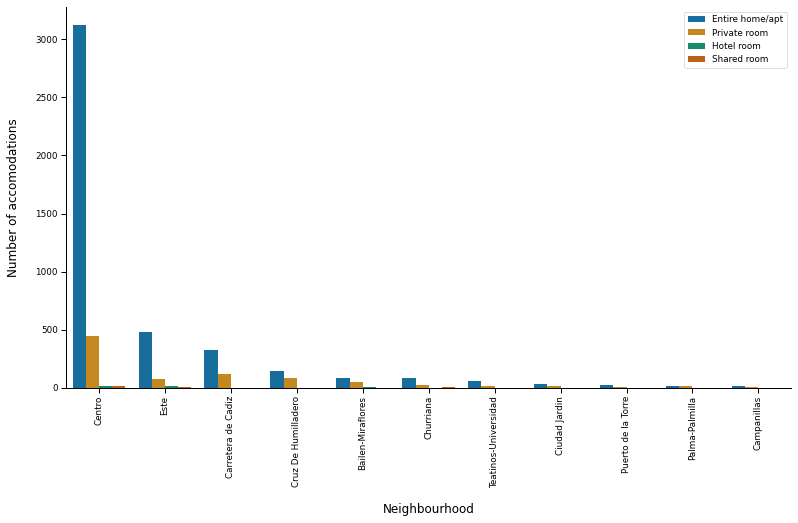

In [18]:
accomodations_per_neighbourhood_type = X.groupby(['neighbourhood_cleansed', 'room_type'])['id'].count().sort_values(ascending=False).reset_index()
display(accomodations_per_neighbourhood_type)

# plot
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(13, 7))
sns.barplot(x='neighbourhood_cleansed', y='id', data=accomodations_per_neighbourhood_type, hue='room_type', orient='v', palette='colorblind')
plt.xlabel(xlabel='Neighbourhood', labelpad=15, fontsize=12)
plt.ylabel(ylabel='Number of accomodations', labelpad=15, fontsize=12)
plt.legend(loc='upper right')
plt.xticks(rotation=90)
sns.despine()

## Price per neighbourhood and type of room

Now, let's see the the price per night in each neighbourhood and type of room. 

We have spotted some very extreme values in the sample, with entire apartments reaching 8000€, but even private rooms reaching more than that! Although this could be variabily in the sample, we will have to remove these outliers.

In research, a common criteria is to remove those values that are 2 standard deviations above or below the mean, so we will see if it is neccesary to apply that criterion to our sample after exploring those rooms in more detail.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Este'),
  Text(1, 0, 'Centro'),
  Text(2, 0, 'Carretera de Cadiz'),
  Text(3, 0, 'Bailen-Miraflores'),
  Text(4, 0, 'Churriana'),
  Text(5, 0, 'Cruz De Humilladero'),
  Text(6, 0, 'Teatinos-Universidad'),
  Text(7, 0, 'Palma-Palmilla'),
  Text(8, 0, 'Puerto de la Torre'),
  Text(9, 0, 'Ciudad Jardin'),
  Text(10, 0, 'Campanillas')])

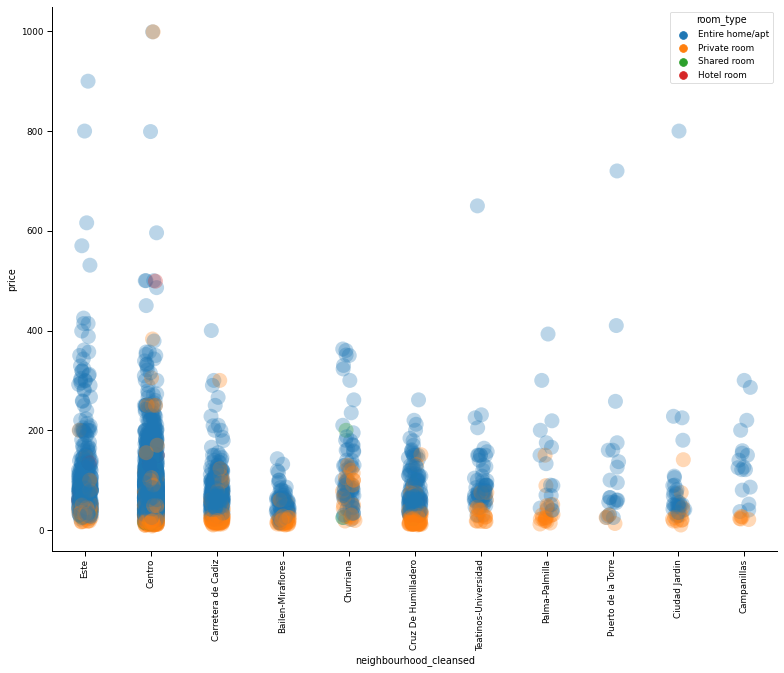

In [21]:
fig, ax = plt.subplots(figsize=(13, 10))
sns.stripplot(x=X['neighbourhood_cleansed'], y=y, hue=X['room_type'], size=15, alpha=.3)
sns.despine()
plt.xticks(rotation=90)

Okay, so it seems that Moriya is renting his/her 'Grandiose Glorious Villa with Heated Outdoor Pool', as he asks for a minimum 91 nights, we will drop this case. However, looking for additional information in Airbnb website, it seems that Unisierra apartments cost around 80-100€ per night, so we will keep their price in 80€ as it seems to be an error. We will also keep the price of Hotel Zenit Malaga in 90€. We will set Francisco's apartment to the same 80€ as the other cases.

In [23]:
display(y[y > 5000])

Series([], Name: price, dtype: float64)

In [456]:
# drop Moriya's accomodation
#listings.drop(listings.loc[listings['id']==42591580].index, inplace=True)

# define conditions
#condition_zenit = (listings['host_name'] == 'Hotel Zenit Malaga') & (listings['price'] > 5000)
#condition_unisierra = (listings['host_name'] == 'Unisierra') & (listings['price'] > 5000)
#condition_francisco = (listings['host_name'] == 'Francisco') & (listings['price'] > 5000)

# modify prices
#listings.loc[condition_zenit, 'price'] = 80
#listings.loc[condition_unisierra, 'price'] = 91
#listings.loc[condition_francisco, 'price'] = 80

#listings[listings['host_name'].str.contains('Unisierra|Zenit')]

## Type of room per neighbourhood

As expected, we can see that at the bottom of the distribution of each neighbourhood we can find most of the private rooms offered in Airbnb website, whereas the rest of the distribution belong to entire apartments. However, we can see in Málaga Centro some private rooms with prices above 200€!

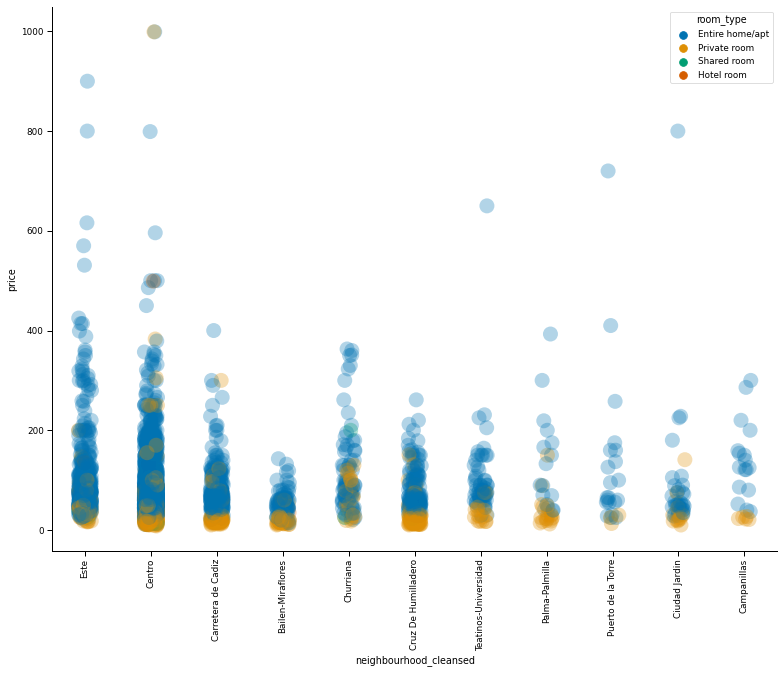

In [24]:
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(13, 10))
sns.stripplot(x=X['neighbourhood_cleansed'], y=y, hue=X['room_type'], palette='colorblind', size=15, alpha=.3)
plt.xticks(rotation=90)
sns.despine()

## Prices map

Now that we have fixed the outliers concerning prices, let's plot a scatter plot based on the locations of each accomodation, and using the price as a hue marker!

Oh! What a pity... not much difference is reflected in the scatter plot, so maybe it will be more convenient to create custom ranges of prices, for example, based on quantiles.

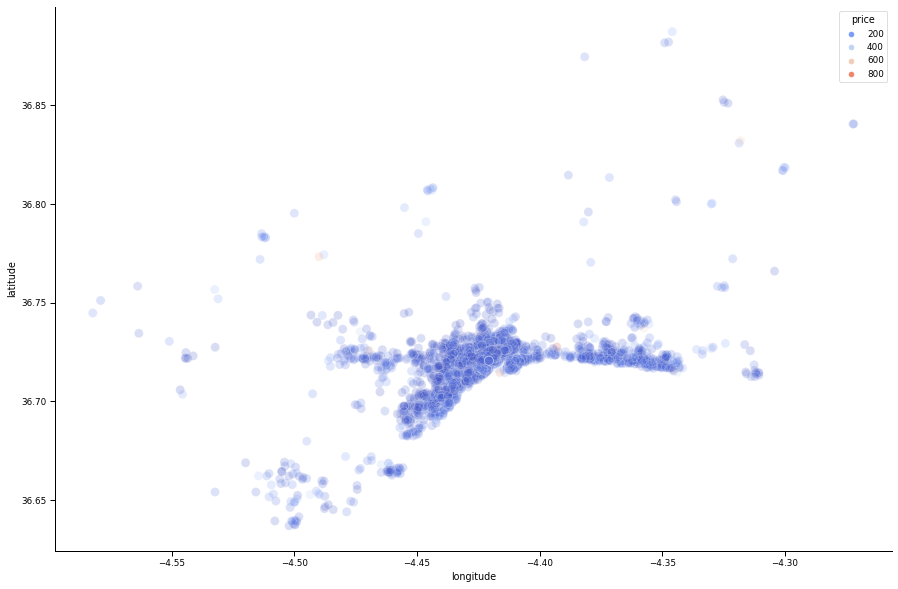

In [25]:
ax, fig = plt.subplots(figsize=(15, 10))
#colors = plt.cm.get_cmap('RdYlBu')
ax = sns.scatterplot(x='longitude', y='latitude', data=X, hue=y, palette='coolwarm', alpha=.2, s=80)
sns.despine()

When we create out own ranges of prices based on percentiles, we can see a clear distinction of prices. As you go next to the coast the prices increase. This is quite normal, as people will be more willing to pay more just to be next to the beach, while most of the cheapest accomodations are in the interior part of the city. However, we find, some exceptions in the mountains. This could be related to bigger houses in the interior part of the province, that are often rented by big groups of people to spend a relaxed holidays.

It is interesting that most of the accomodations offered in Churriana are quite expensive. We know that Málaga-Costa del Sol airport is in that area, so it could be possible that these range of prices are due to this. 

It would be interesting to check if the size of the accomodation is related to its location, for that, we can use 'bedrooms' or 'property_type' columns from listings_details.

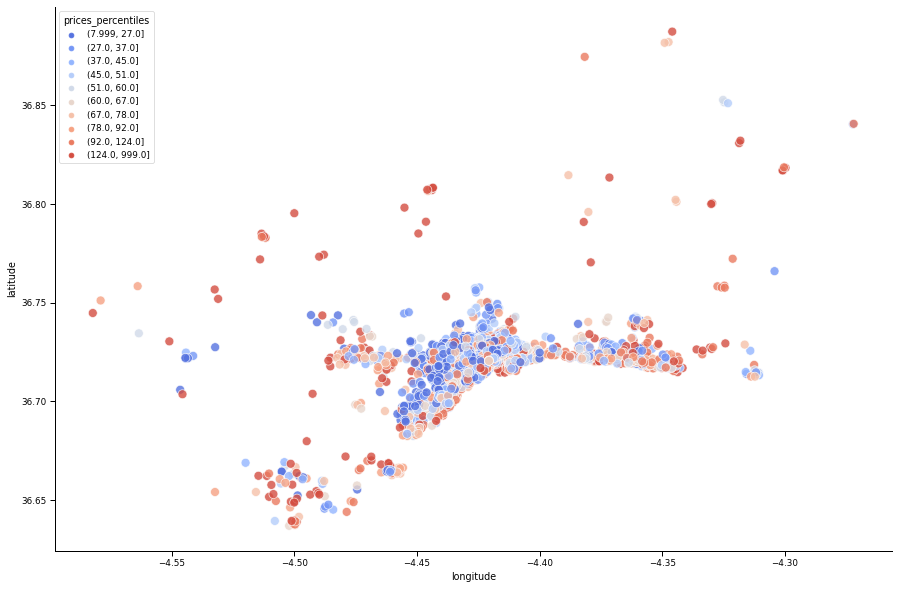

In [26]:
X['prices_percentiles'] = pd.qcut(x=y, q=10)
fig, ax = plt.subplots(figsize=(15, 10))
#colors = plt.cm.get_cmap('RdYlBu')
sns.scatterplot(x='longitude', y='latitude', data=X, hue='prices_percentiles', palette='coolwarm', alpha=.8, s=80)
sns.despine()

## Type of room map

This map is quite interesting. We can see that cose to the coast, most of the offered accomodations seem to be entire apartments, while you go the interior part of the city you can find private rooms most likely. This is quite expected, as the main attraction of Málaga is it's sunny beaches, and of course, most of the tourist would like to be next to the see enjoying the sun.

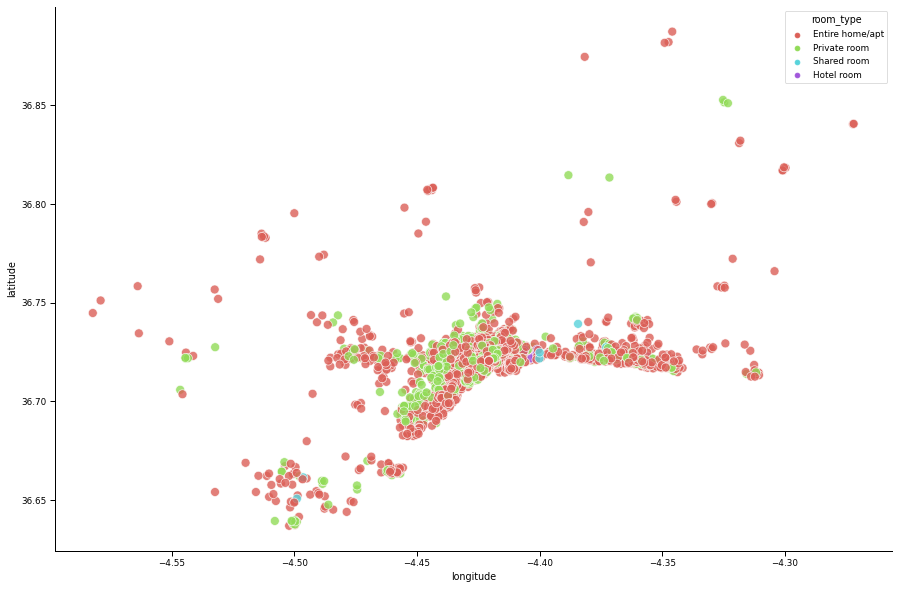

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
#colors = plt.cm.get_cmap('RdYlBu')
sns.scatterplot(x='longitude', y='latitude', data=X, hue='room_type', palette='hls', alpha=.8, s=80)
sns.despine()

## New features

We will create a new feature that entails the size of each accomodation based on the number of people the house/flat can accomodates. We will differentiate between small (3 of less people), medium (between 4 and 7 people) and large (between 8 and 20 people)

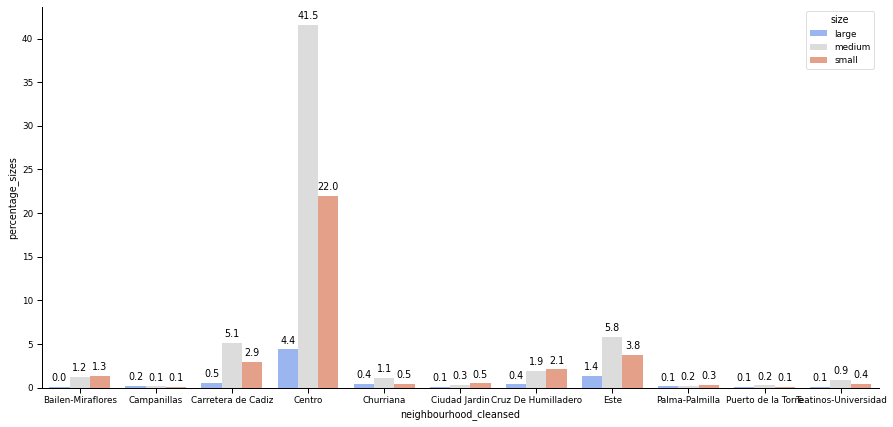

In [28]:
size_1 = (X['accommodates'] <= 3)
size_2 = (X['accommodates'] >= 4) & (X['accommodates'] <= 7)
size_3 = (X['accommodates'] >= 8) & (X['accommodates'] <= 20)

X['size'] = ''
X.loc[size_1, 'size'] = 'small'
X.loc[size_2, 'size'] = 'medium'
X.loc[size_3, 'size'] = 'large'

perc_sizes_neighbourhood = X.groupby(['neighbourhood_cleansed', 'size']).agg({'id': 'count'}).reset_index()
perc_sizes_neighbourhood['percentage_sizes'] = perc_sizes_neighbourhood.groupby(['neighbourhood_cleansed', 'size'])['id'].apply(lambda x: x * 100 / sum(perc_sizes_neighbourhood['id']))

fig, ax = plt.subplots(figsize=(15, 7))
g = sns.barplot(x='neighbourhood_cleansed', y='percentage_sizes', data=perc_sizes_neighbourhood, hue='size', orient='v', palette='coolwarm')
for note in g.patches:
    g.annotate(format(note.get_height(), '.1f'), (note.get_x() + note.get_width() / 2., note.get_height()), 
               ha='center', va='center', xytext=(0,9), textcoords='offset points')
sns.despine()

## Size of room and prices map

By this plot we can confirm that most of the accomodations far away from the city are medium and large sizes, so it is possible that these are appartaments mostly rented by groups.

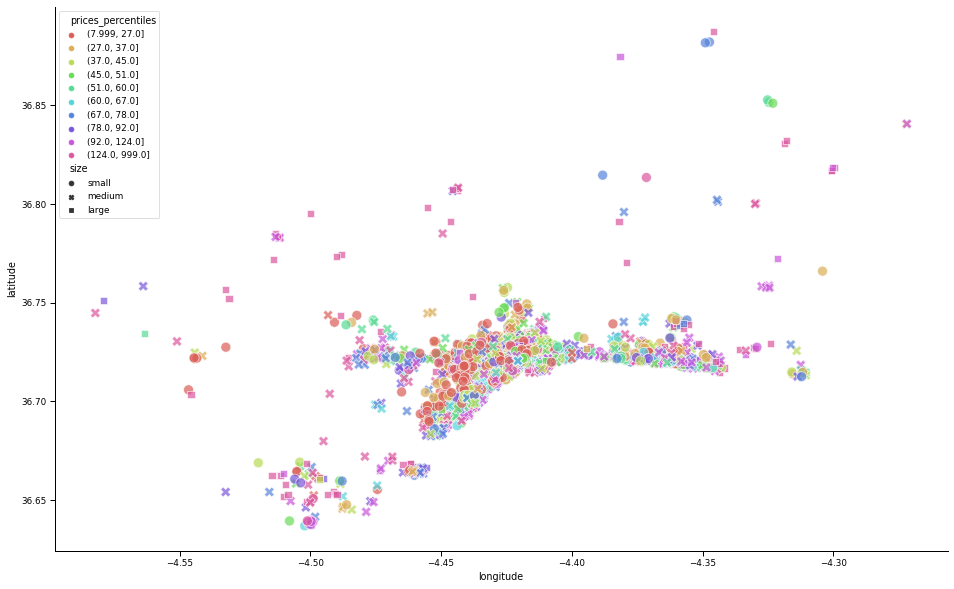

In [29]:
fig, ax = plt.subplots(figsize=(16, 10))
#colors = plt.cm.get_cmap('RdYlBu')
sns.scatterplot(x='longitude', y='latitude', data=X, hue='prices_percentiles', style='size', palette='hls', alpha=.7, s=100)
sns.despine()

## Superhost map

It seems that be a superhost is quite difficult, as we only have a few cases. We can also see that they are not distributed equally around the city.

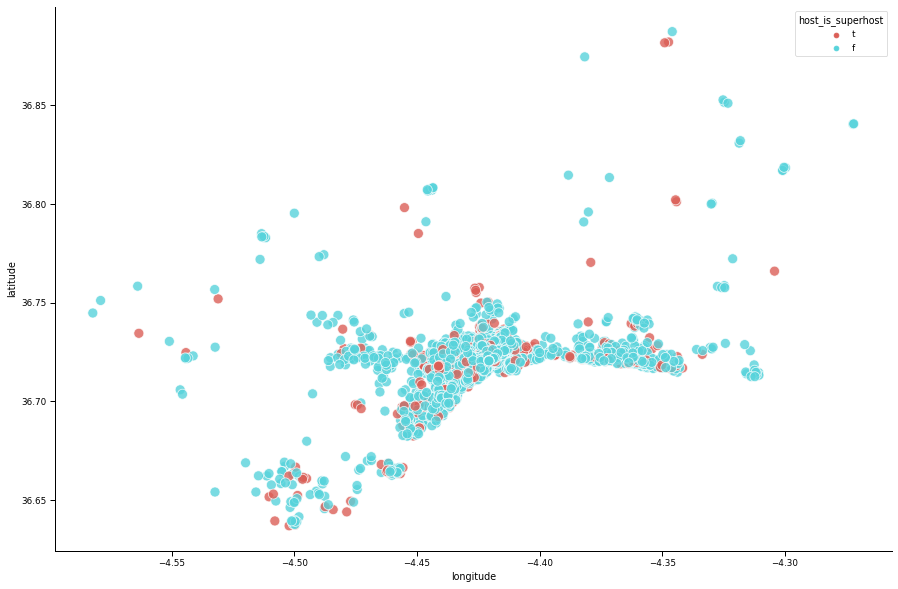

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
#colors = plt.cm.get_cmap('RdYlBu')
sns.scatterplot(x='longitude', y='latitude', data=X, hue='host_is_superhost', palette='hls', alpha=.8,s=100)
sns.despine()

## Percentage of accomodations per size

Then, the majority of rooms offered in Airbnb Málaga are medium (58.40) and small size (33.94), whereas large rooms only represent 7.66% of the total of accomodations.

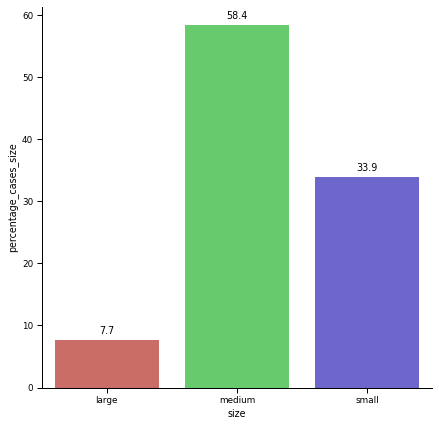

In [31]:
cases_size = X.groupby(['size']).agg({'id': 'count'}).reset_index()
cases_size['percentage_cases_size'] = cases_size['id'] * 100 / sum(cases_size['id'])

sns.set_context('paper')
fig, ax = plt.subplots(figsize=(7, 7))
g = sns.barplot(x='size', y='percentage_cases_size', data=cases_size, orient='v', palette='hls')
for note in g.patches:
    g.annotate(format(note.get_height(), '.1f'), (note.get_x() + note.get_width() / 2., note.get_height()), 
               ha='center', va='center', xytext=(0,9), textcoords='offset points')
sns.despine()

## Percentage of accomodations per size and price group

We can see from this plot that the majority of large accomodations fall in the range between 92€ and 999€ per night, whereas the small accomodations are mostly in the range between 8€ and 50€ per night. The medium size accomodations are more balanced between differences ranges of prices.

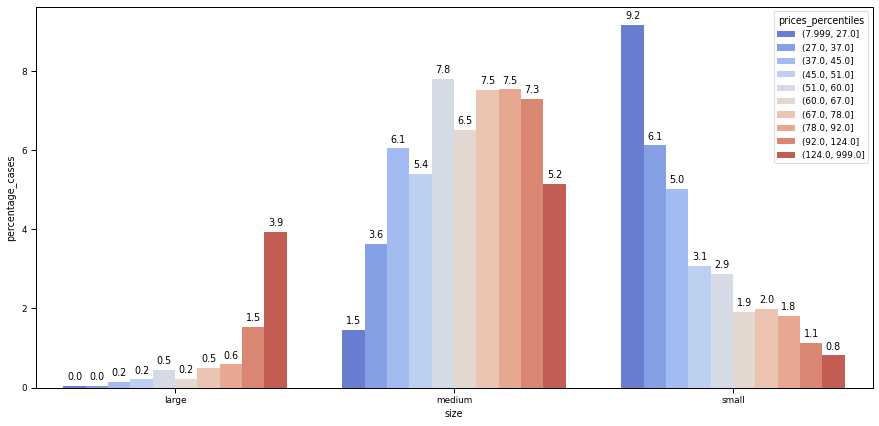

In [32]:
cases = X.groupby(['prices_percentiles', 'size']).agg({'id': 'count'}).reset_index()
cases['percentage_cases'] = cases.groupby(['prices_percentiles', 'size'])['id'].apply(lambda x: x * 100 / sum(cases['id']))

fig, ax = plt.subplots(figsize=(15, 7))
g = sns.barplot(x='size', y='percentage_cases', data=cases, hue='prices_percentiles', orient='v', palette='coolwarm')
for note in g.patches:
    g.annotate(format(note.get_height(), '.1f'), (note.get_x() + note.get_width() / 2., note.get_height()), 
               ha='center', va='center', xytext=(0,9), textcoords='offset points')

## Data distribution

### Explore categorical variables

Let's see how price is distributed between neighbourhoods. It is known that prices could have a non-normal distribution, so it could be possible that we will need to apply some transformation to data.

As we have categorical variables, we will extract the unique values of that variable into a list, an explore the number of categories in each one of them.

In [33]:
categorical_cols = X.select_dtypes(['object']).columns.to_list()

for col in categorical_cols:
    list_cat = X[col].unique().tolist()
    print('We have ' + str(len(list_cat)) + ' categories in ' + col)

We have 2 categories in host_is_superhost
We have 11 categories in neighbourhood_cleansed
We have 51 categories in property_type
We have 4 categories in room_type
We have 2 categories in instant_bookable
We have 2 categories in bathroom_type
We have 3 categories in size


Let's check how many categories do we have with less than 10 cases. Wow! We have a lot of property types that meet this criteria. A the sample size of some groups is too small, we should exclude this entire category, as room type already covers this in only 4 room types.

In [35]:
cases_size = X.groupby(['property_type']).agg({'id': 'count'}).reset_index()
cases_size.rename(columns={'id': 'no_cases'}, inplace=True)
display(cases_size[cases_size['no_cases'] <= 10].sort_values(by='no_cases', ascending=True))

,property_type,no_cases
48,Shared room in hotel,1
36,Private room in vacation home,1
49,Shared room in house,1
46,Shared room in guesthouse,1
27,Private room in cottage,1
39,Room in bed and breakfast,1
23,Private room in camper/rv,1
41,Room in casa particular,1
17,Entire vacation home,1
12,Entire home/apt,1


### Drop not neccessary variables

We see that quite a few categories have less than 10 cases. We should consider to recode this variable. As this is not the scope of this notebook and I am not an expert in Airbnb data, we are going to consider only 'room_type' and remove this column. We will also drop 'id' as we do not need it already in further analysis.

In [36]:
X = X.drop(columns=['property_type', 'id', 'host_id'])

### Explore the distribution of numerical variables

Okay, phew! That looks like a lot of tests. Now that we have finished with categorical variables (that I did not want to recode as I am not an expert in Airbnb data, unless they want to hire and training me (wink, wink Airbnb...)), let's explore correlations between continuous variables.

But first! We should explore the distribution of these variables, just to know if should apply Pearson or Spearman method.

In [41]:
def plot_dist(df, dv_list, transformation=None):
      
    for dv in dv_list:
        
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(df[dv], fit=norm, color='indianred', ax=ax[0])
        stats.probplot(df[dv].dropna(), plot=ax[1])
        plt.show()

In [42]:
numeric_variables = X.select_dtypes(['number']).columns.to_list()

So from the distribution we can see that longitude have a normal distribution. Latitute could be considered normally distributed, but it has a left skew. And obviously the rest of variables (accomodates, bedrooms and beds) are not normally distributed. So we will apply Spearman method for correlation.

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


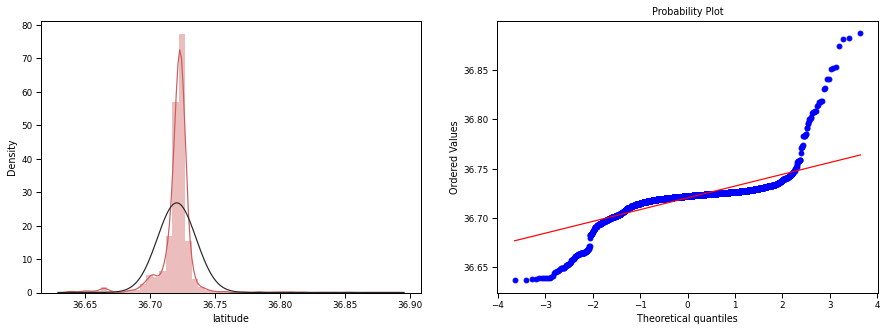

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


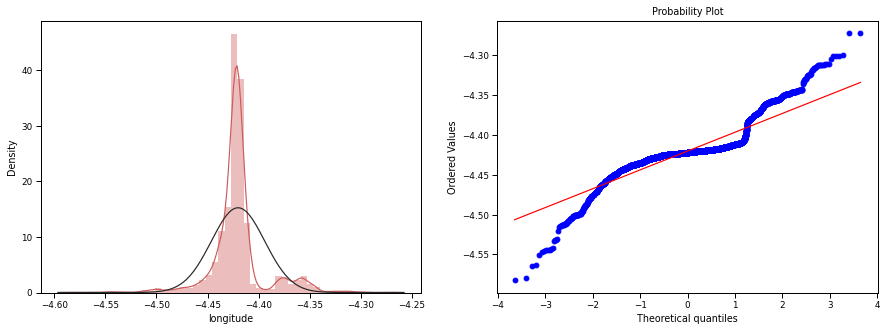

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


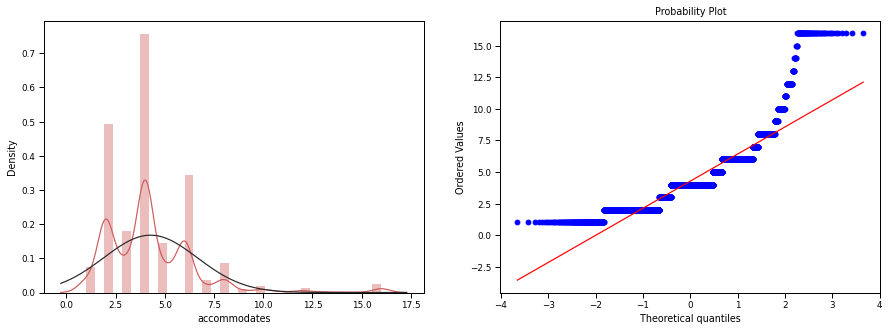

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


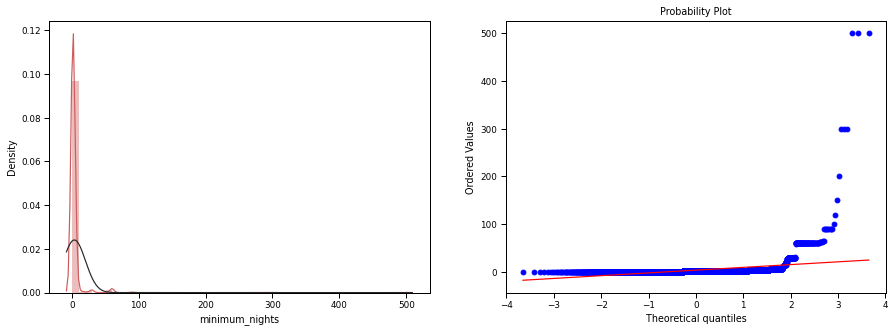

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


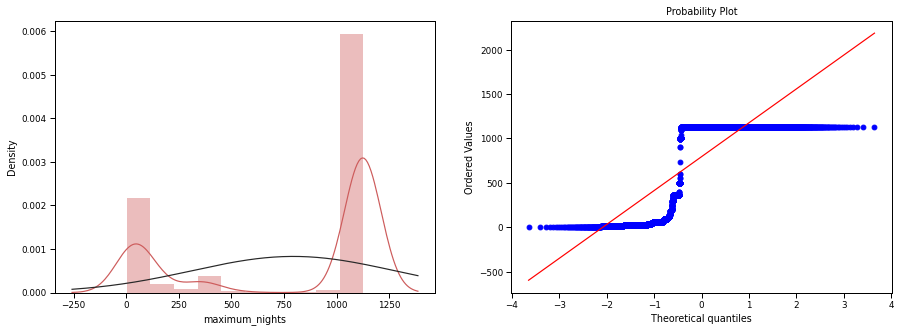

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


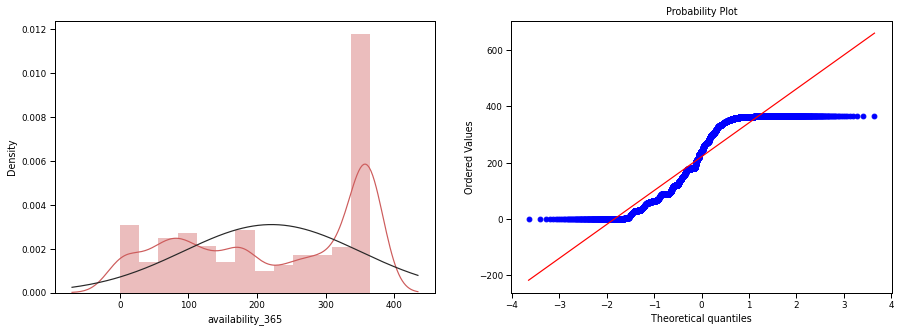

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


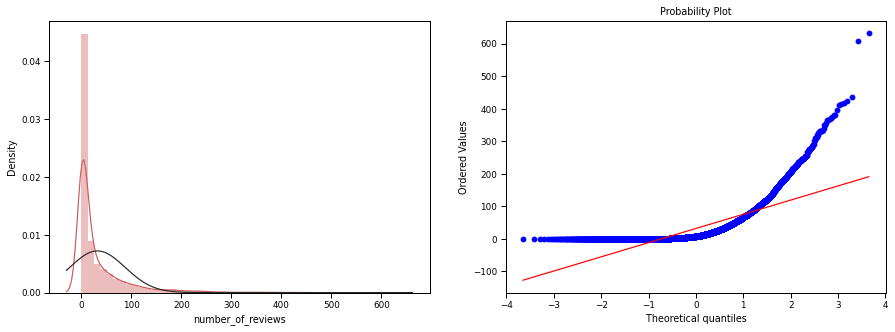

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


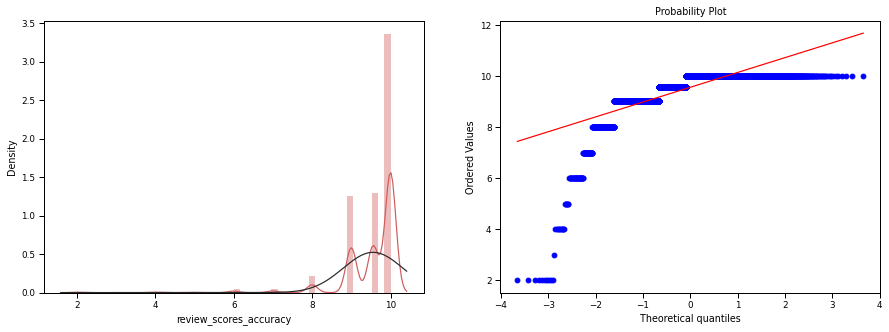

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


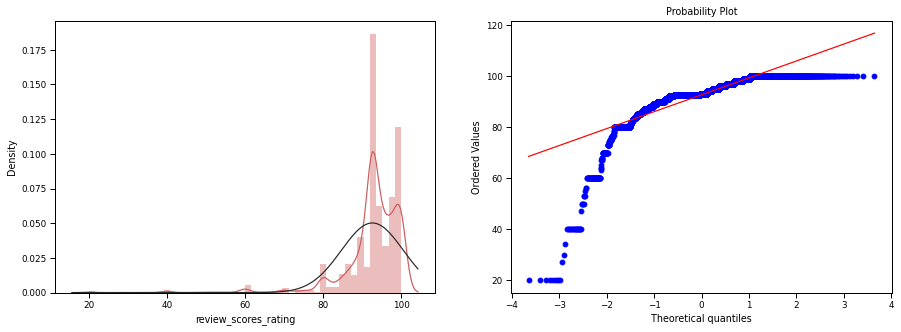

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


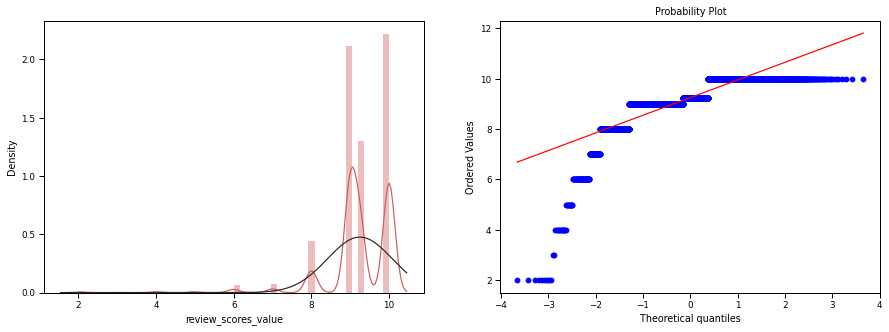

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


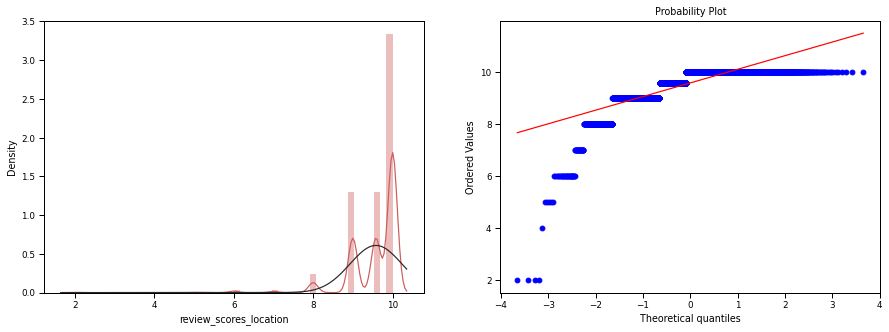

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


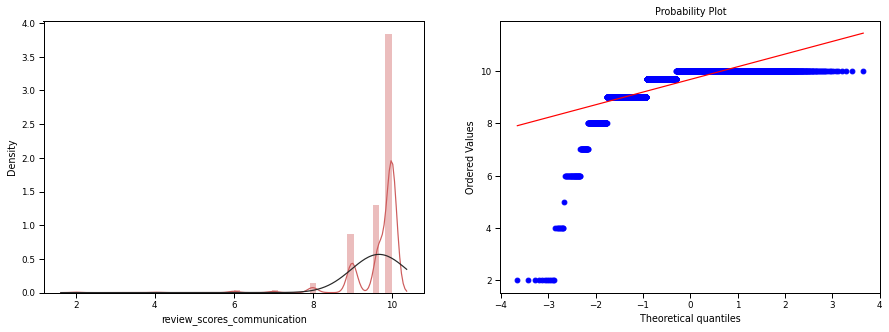

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


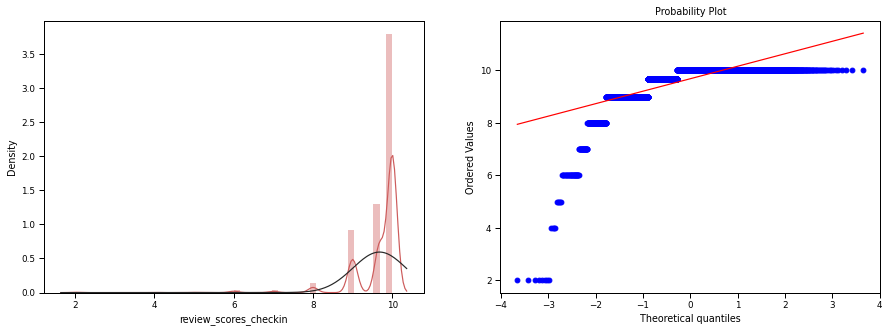

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


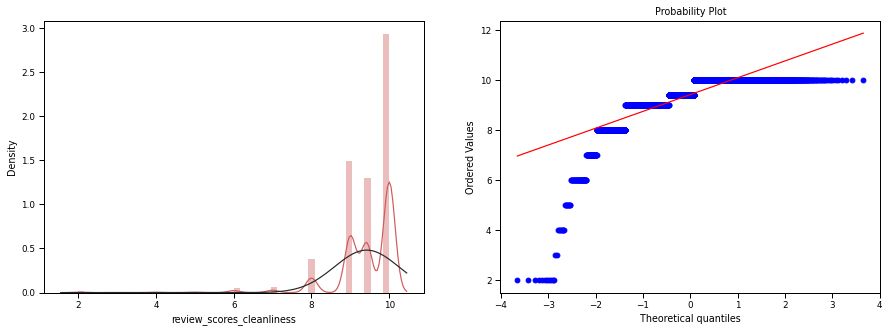

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


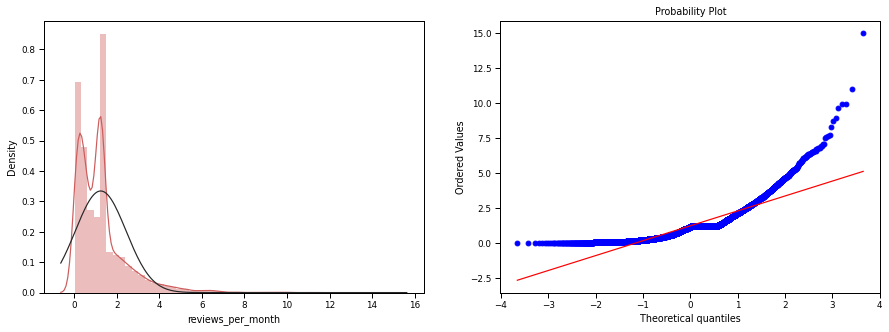

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


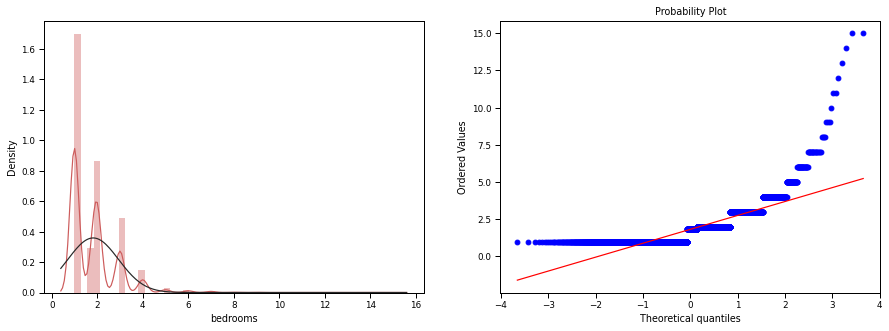

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


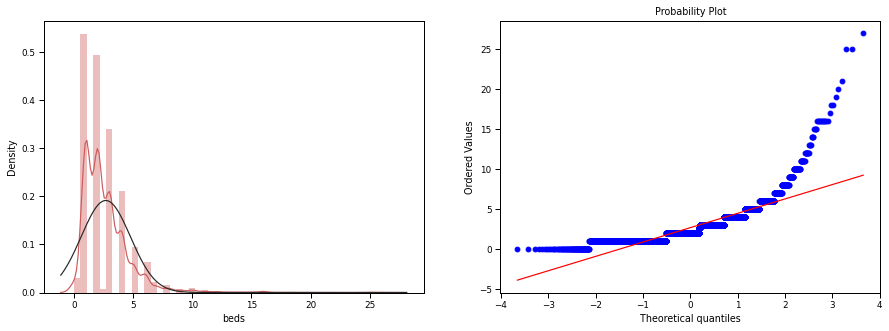

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


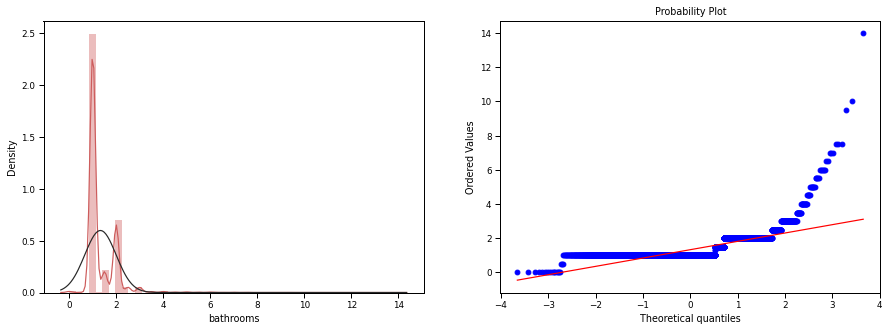

In [43]:
plot_dist(X, numeric_variables)

### Explore distribution of price per neighbourhood

In [15]:
def plot_dist_per_group(df, list_of_groups, factor_column_name, dv_column_name, transformation=None):
      
    for group in list_of_groups:
        
        df_slice = df[df[factor_column_name] == group][dv_column_name]
        
        if transformation != None:
            df_slice = df_slice.apply(transformation)
        else:
            df_slice = df_slice
        
        print('Distribution for group: ' + str(group))
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(df_slice, fit=norm, color='indianred', ax=ax[0])
        stats.probplot(df_slice.dropna(), plot=ax[1])
        plt.show()

As expected, the distribution of price is not normally distributed, that is why we will apply a log transformation and check the distribution again.

Distribution for group: Este


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


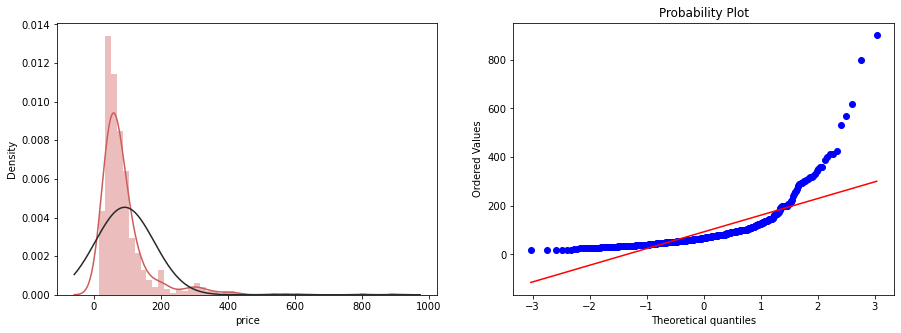

Distribution for group: Centro


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


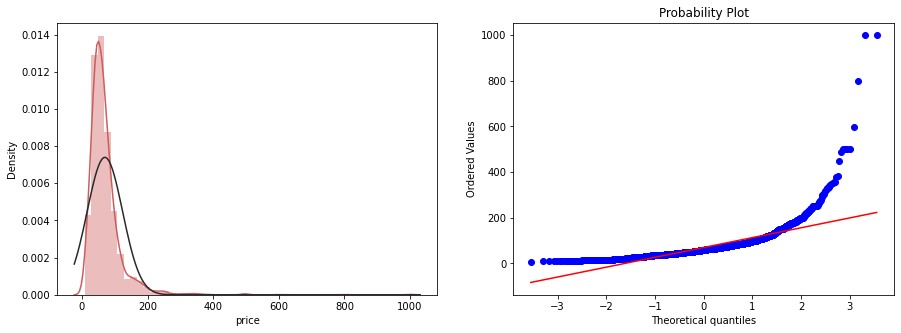

Distribution for group: Carretera de Cadiz


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


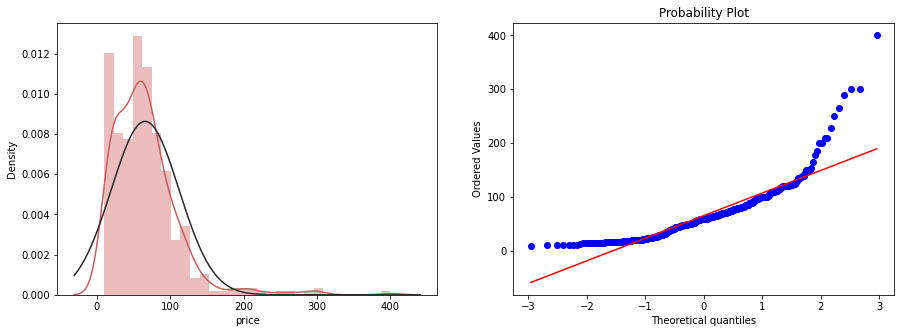

Distribution for group: Bailen-Miraflores


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


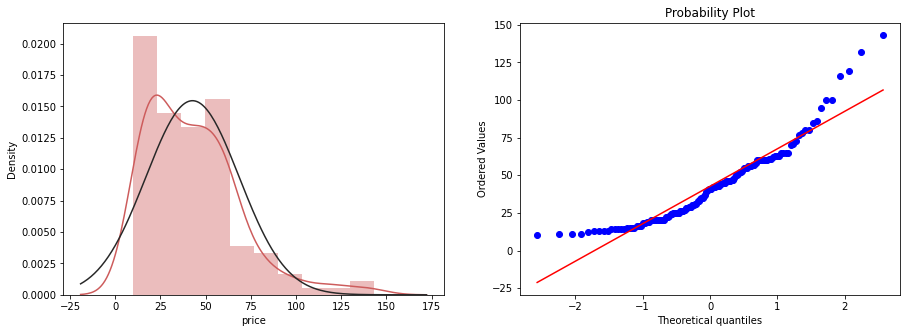

Distribution for group: Churriana


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


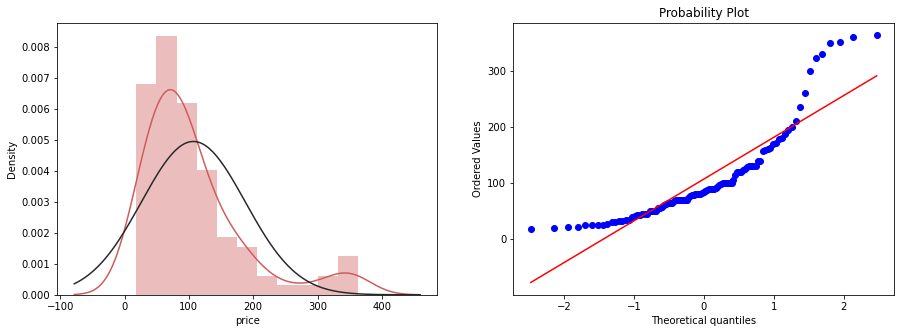

Distribution for group: Cruz De Humilladero


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


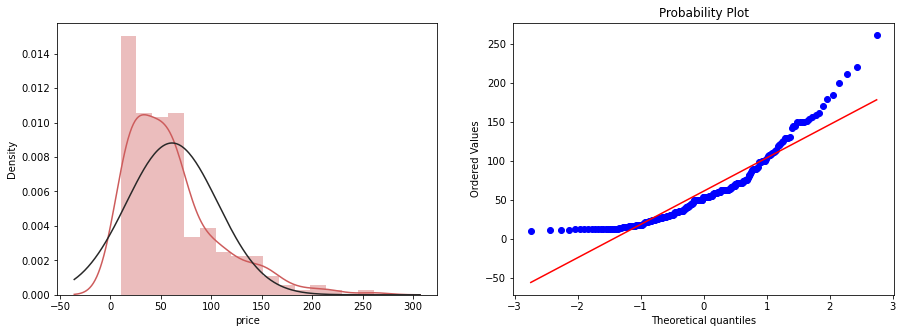

Distribution for group: Teatinos-Universidad


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


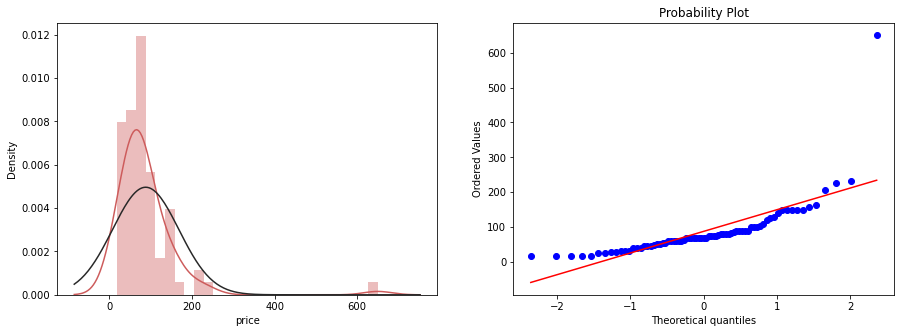

Distribution for group: Palma-Palmilla


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


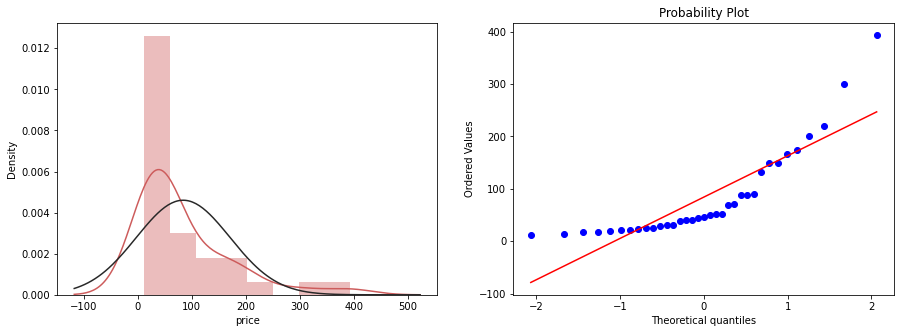

Distribution for group: Puerto de la Torre


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


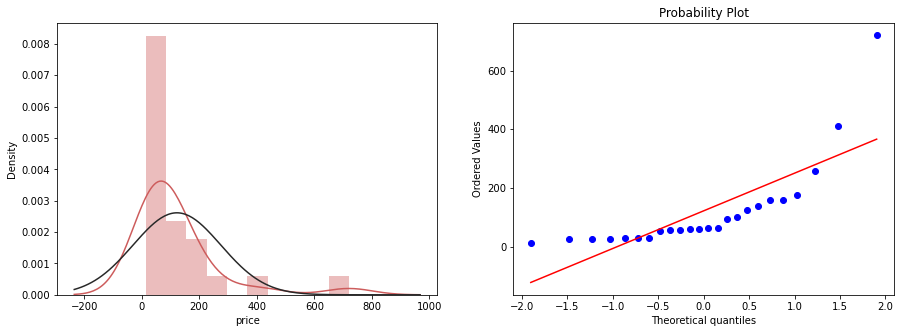

Distribution for group: Ciudad Jardin


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


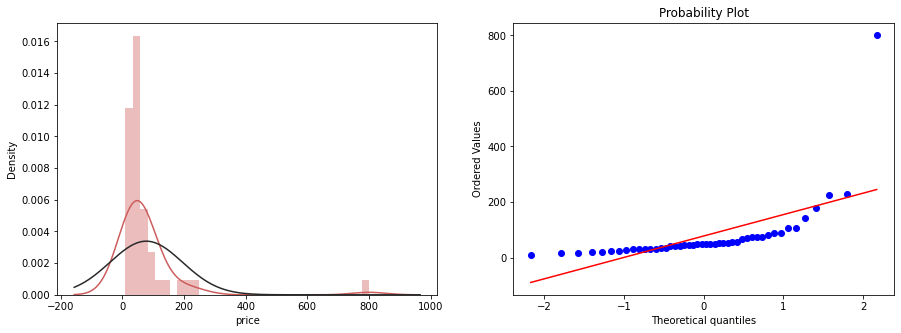

Distribution for group: Campanillas


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


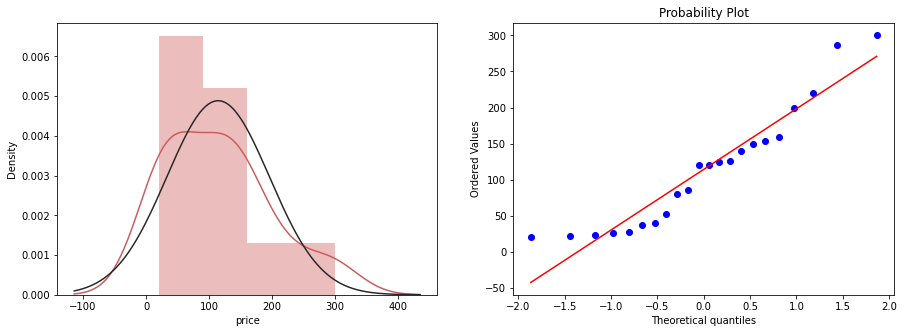

In [16]:
plot_dist_per_group(listings, neighbourhoods_list, 'neighbourhood_cleansed', 'price')

After applying a logarithmic transformation we see that the price distribution of each neighbourhood approximates to a normal distribution. We can chose to perform a non-parametric test as Kuskal-Wallis, as the distribution of some neighbourhood still is non-normal distributed. However, is not far from beign normal, so we will still go on with ANOVA analysis.

We should also consider that in some neighbourhoods the sample size is limited, compared to Centro and Este, which are easy to make normally distributed.

Distribution for group: Este


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


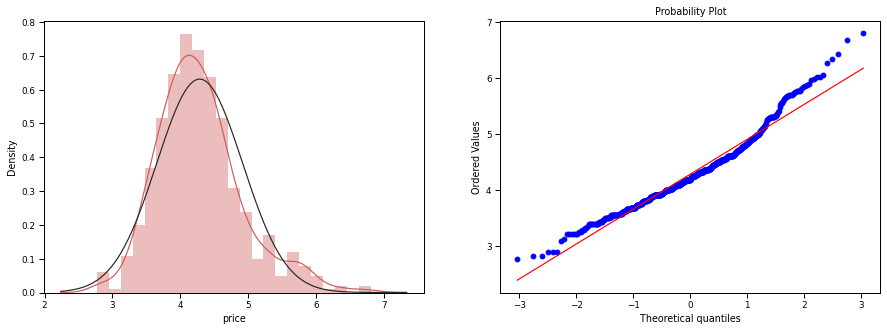

Distribution for group: Centro


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


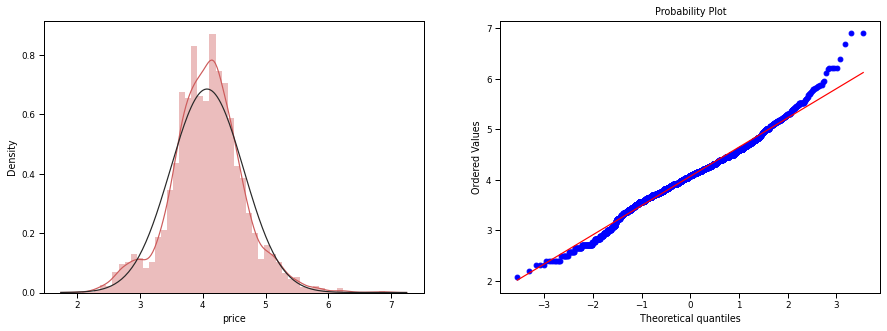

Distribution for group: Carretera de Cadiz


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


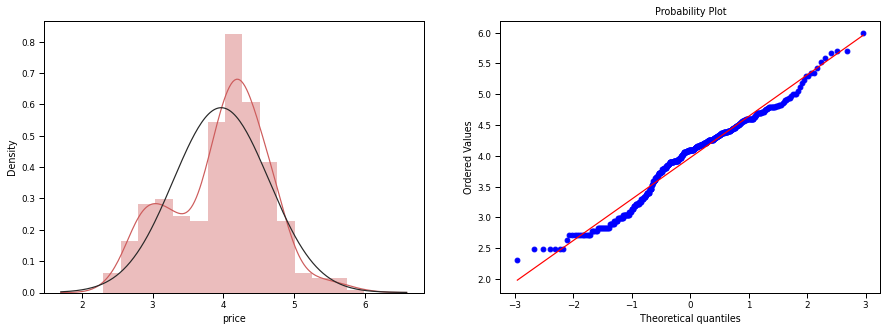

Distribution for group: Bailen-Miraflores


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


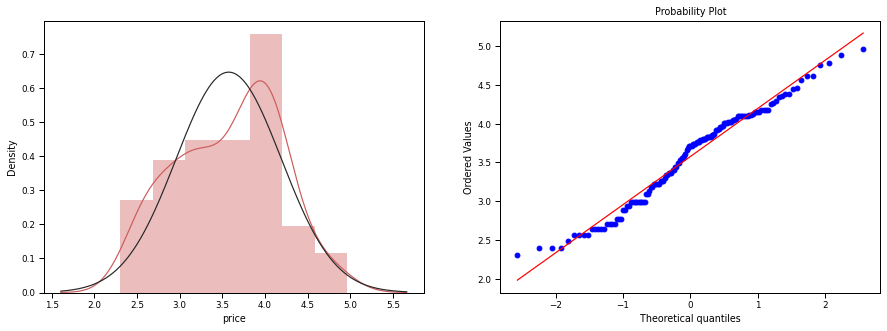

Distribution for group: Churriana


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


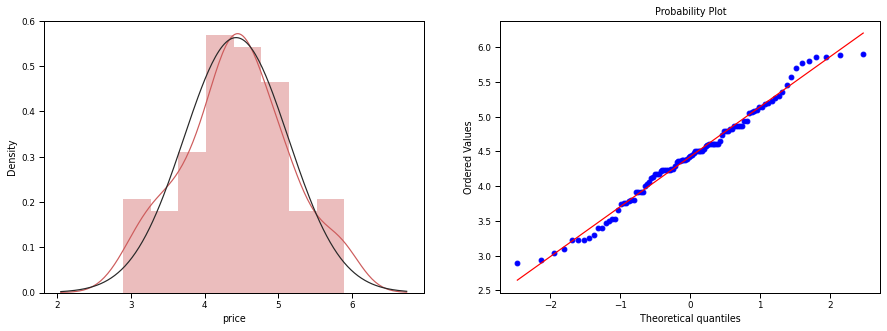

Distribution for group: Cruz De Humilladero


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


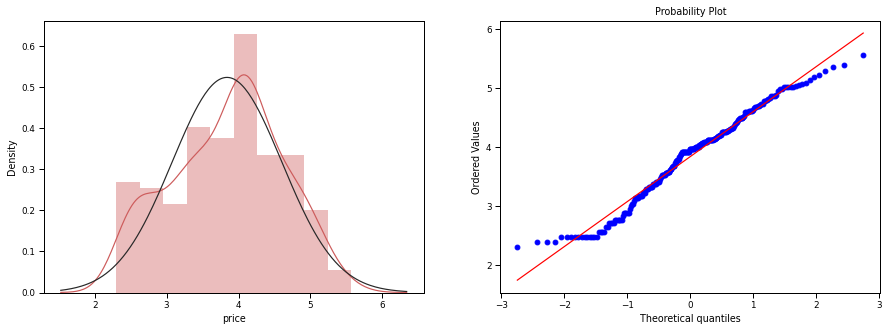

Distribution for group: Teatinos-Universidad


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


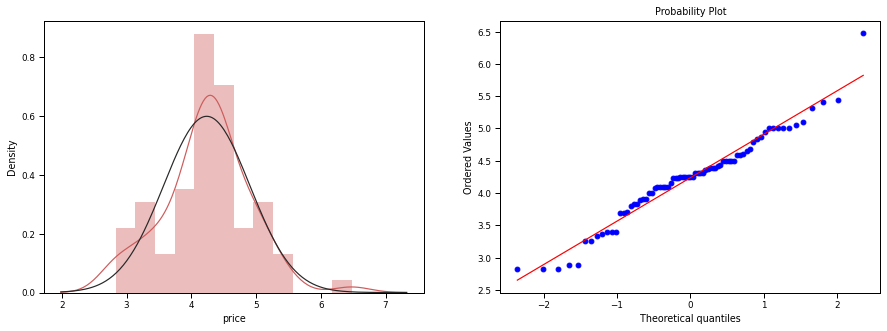

Distribution for group: Palma-Palmilla


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


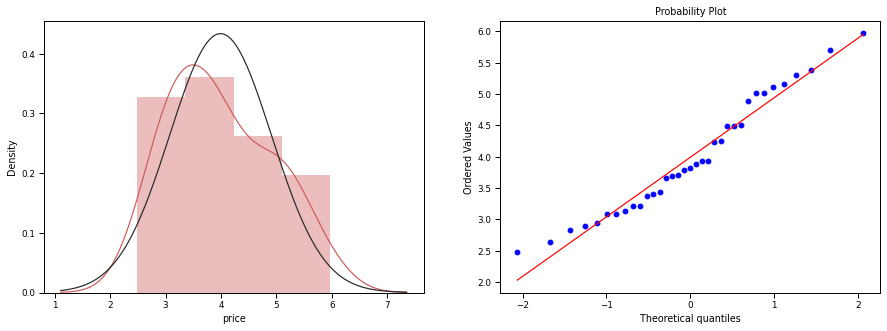

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Distribution for group: Puerto de la Torre


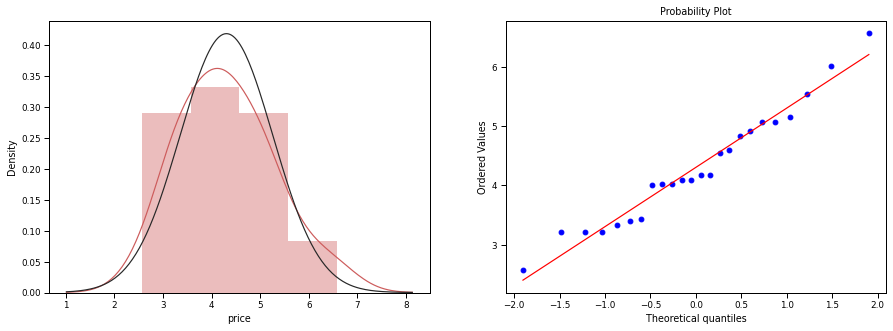

Distribution for group: Ciudad Jardin


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


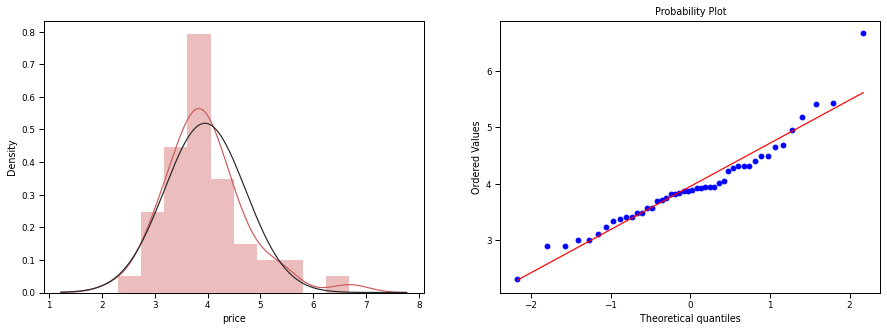

Distribution for group: Campanillas


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


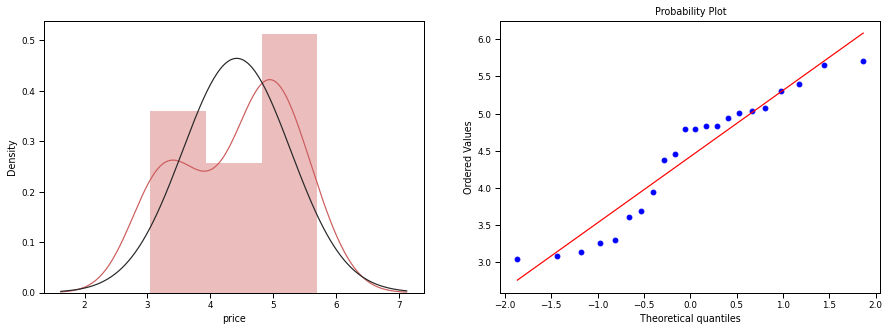

In [30]:
plot_dist_per_group(listings, neighbourhoods_list, 'neighbourhood_cleansed', 'price', np.log)

As log transformation approximates price to a normal distribution, let's see the minimum value in price column, as a division by zero should be a problem in this case. If we do not have a 0 value, then we can just apply log transformation without adding 1 to price column to avoid infinite values.

In [64]:
min_price = listings['price'].min()

print('The minimum price for an Airbnb accomodation in Málaga is: ' + str(min_price) + '€')

The minimum price for an Airbnb accomodation in Málaga is: 8.0€


As the minimum value for price is 8€, we can just simply apply log transformation over the original price.

In [65]:
listings['price'] = np.log(listings['price'])
display(listings)

,latitude,longitude,neighbourhood_cleansed,room_type,size,accommodates,bedrooms,beds,minimum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_communication,price
0,36.720310,-4.356270,Este,Entire home/apt,small,3,2.0,2.0,5,228,89,90.0,9.0,10.0,3.135494
1,36.727230,-4.407200,Centro,Entire home/apt,medium,5,3.0,5.0,3,364,18,91.0,9.0,10.0,5.192957
2,36.719340,-4.359420,Este,Private room,small,3,1.0,0.0,5,365,69,94.0,9.0,10.0,2.833213
3,36.726060,-4.365410,Este,Shared room,small,2,1.0,2.0,2,301,36,95.0,10.0,10.0,3.663562
4,36.790870,-4.381980,Este,Entire home/apt,large,12,4.0,10.0,5,364,3,100.0,9.0,10.0,5.247024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5284,36.720615,-4.420641,Centro,Entire home/apt,medium,4,1.0,1.0,1,65,0,NaN,NaN,NaN,4.110874
5285,36.720615,-4.420641,Centro,Entire home/apt,medium,5,2.0,2.0,1,65,0,NaN,NaN,NaN,4.174387
5286,36.720615,-4.420641,Centro,Entire home/apt,medium,6,2.0,3.0,1,56,0,NaN,NaN,NaN,4.330733
5287,36.720615,-4.420641,Centro,Entire home/apt,medium,5,2.0,3.0,1,65,0,NaN,NaN,NaN,4.442651


# Train-test-validation split

Let's try to have 70% train, 15% test and 15% validate.

https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

In [ ]:
train_X, validate_X, test_X = np.split(X.sample(frac=1), [int(.7*len(X)), int(.85*len(X))])
train_y, validate_y, test_y = np.split(y.sample(frac=1), [int(.7*len(y)), int(.85*len(y))])

# Feature selection of categorical variables

Let's check now if there is a significant effect of categorical variables (neighbourhood and room type)

As I am not currently employed in Airbnb, I do not know if there is a system that they use to code categorical variables as these. So in this case I am only going to explore if there is a significant effect of each categorical variable on the price. We will use Analysis of Variance (ANOVA) for this. This statistical method gives us an F statistics. It is know that the higher the F statistic, the higher the correlation will be with our dependent variable.

The test yield a F = 25.22 value using ANOVA over price. We will have to explore these differences between neighbourhoods performing t-tests. The same significant effect is yield in the not transformed data applying a non-parametric test as Kruskal-Wallis.

In any case, we should consider Neighbourhood as a significant factor to contribute to our models, as we find an association between price and neighbourhood.

In [66]:
anova_neighbourhood = pg.anova(listings, dv='price', between='neighbourhood_cleansed', detailed=True, effsize='np2')
kruskal_neighbourhood = pg.kruskal(listings, dv='price', between='neighbourhood_cleansed', detailed=True)
display(anova_neighbourhood.round(3), kruskal_neighbourhood.round(3))

,Source,SS,DF,MS,F,p-unc,np2
0,neighbourhood_cleansed,96.642,10,9.664,25.229,0.0,0.046
1,Within,2014.850,5260,0.383,NaN,NaN,NaN


,Source,ddof1,H,p-unc
Kruskal,neighbourhood_cleansed,10,184.239,0.0


We will perform t-tests between different neighbourhood to see where the differences in prices arise. But first, let's explore how many neighbourhood we have.

Let's create first the possible combination between neighbourhoods and perform t-tests.

In [27]:
def multiple_comparisons(df, list_of_groups, factor_column_name, dv_column_name):
    
    list_results = []
    list_comparisons = []
    
    comparisons = combinations(list_of_groups, 2)
    for name1, name2 in comparisons:
        comparison_tuple = (name1, name2)
        list_comparisons.append(comparison_tuple)

    for tuple_combo in list_comparisons:
        print('Performing t-test for comparison: ' + str(tuple_combo[0]) + ' and ' + str(tuple_combo[1]))
        x = df[df[factor_column_name] == tuple_combo[0]][dv_column_name]
        y = df[df[factor_column_name] == tuple_combo[1]][dv_column_name]
        result = pg.ttest(x=x, y=y, paired=False, tail='two-sided', correction='auto')
        result[['X', 'Y']] = tuple_combo[0], tuple_combo[1]
        list_results.append(result)
        final_results = pd.concat(list_results)
    
    return final_results

Let's perform the t-test comparisons between neighbourhood to dig deeper in the significant differences in Málaga.


We see that the mean price in Bailén-Miraflores is lower compared to the rest of the neighbourhoods, we will explain this in the next paragaph.


Interesting, we see that Carretera de Cadiz has a mean price lower than some neighbourhoods as Campanillas. In Campanillas we found the Technological Park, maybe this could explain why we have some higher prices, as we can find there more hotels or less Airbnb accomodations but more valuable as though for certain business purposes rathen than tourism. The same happens with Churriana, as we find there Málaga-Costa del Sol airport. We can see that also Teoatinos-Universidad is closer to the city center than Carretera de Cadiz. However, we see that Bailén-Miraflores has a lower mean price, this could be possible as Carretera de Cadiz is closer to the beach.


Center area has higher prices compared to Cruz de Humilladero and Bailén-Miraflores. However, Churriana and Campanillas have higher mean price. This could be possible because of the Technological Park and the airport.


Finally, we see that Este area is the most expensive! We all know that Centro area have the harbour, whereas Este have one of the most touristic areas of the city, plus some beautiful beaches. Si, it is not surprising that Este is more expensive than Carretera de Cadiz, Cruz del Humilladero and Bailén-Miraflores.

Performing t-test for comparison: Este and Centro
Performing t-test for comparison: Este and Carretera de Cadiz
Performing t-test for comparison: Este and Bailen-Miraflores
Performing t-test for comparison: Este and Churriana
Performing t-test for comparison: Este and Cruz De Humilladero
Performing t-test for comparison: Este and Teatinos-Universidad
Performing t-test for comparison: Este and Palma-Palmilla
Performing t-test for comparison: Este and Puerto de la Torre
Performing t-test for comparison: Este and Ciudad Jardin
Performing t-test for comparison: Este and Campanillas
Performing t-test for comparison: Centro and Carretera de Cadiz
Performing t-test for comparison: Centro and Bailen-Miraflores
Performing t-test for comparison: Centro and Churriana
Performing t-test for comparison: Centro and Cruz De Humilladero
Performing t-test for comparison: Centro and Teatinos-Universidad
Performing t-test for comparison: Centro and Palma-Palmilla
Performing t-test for comparison: Centro a

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,X,Y
T-test,-9.66,202.32,two-sided,0.00,"[-1.02, -0.68]",1.29,4.901e+15,1.00,Bailen-Miraflores,Churriana
T-test,-7.05,142.69,two-sided,0.00,"[-0.85, -0.48]",1.04,2.907e+08,1.00,Bailen-Miraflores,Teatinos-Universidad
T-test,-4.35,24.49,two-sided,0.00,"[-1.25, -0.45]",1.28,717.903,1.00,Bailen-Miraflores,Campanillas
T-test,-3.62,327.75,two-sided,0.00,"[-0.41, -0.12]",0.37,59.552,0.93,Bailen-Miraflores,Cruz De Humilladero
T-test,-3.56,26.39,two-sided,0.00,"[-1.16, -0.31]",1.07,53.374,1.00,Bailen-Miraflores,Puerto de la Torre
T-test,-2.97,65.52,two-sided,0.00,"[-0.63, -0.12]",0.57,9.669,0.91,Bailen-Miraflores,Ciudad Jardin
T-test,-2.51,42.05,two-sided,0.02,"[-0.75, -0.08]",0.60,3.288,0.88,Bailen-Miraflores,Palma-Palmilla
T-test,-5.90,147.42,two-sided,0.00,"[-0.61, -0.3]",0.67,1.504e+06,1.00,Carretera de Cadiz,Churriana
T-test,-3.19,100.84,two-sided,0.00,"[-0.43, -0.1]",0.40,16.839,0.89,Carretera de Cadiz,Teatinos-Universidad
T-test,-2.38,22.24,two-sided,0.03,"[-0.85, -0.06]",0.66,2.694,0.85,Carretera de Cadiz,Campanillas


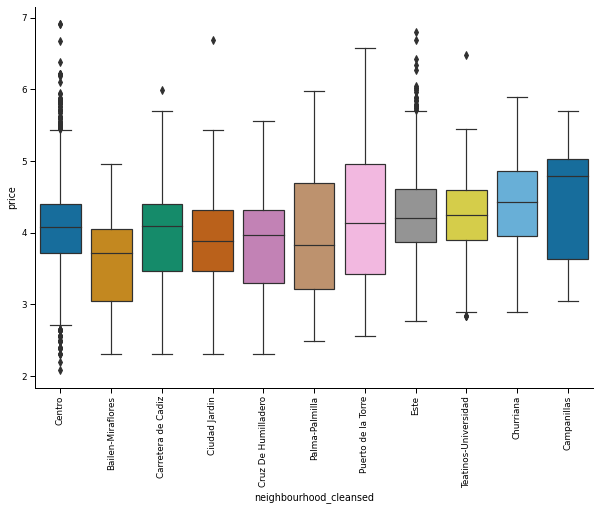

In [89]:
significant_ttest = multiple_comparisons(airbnb_filtered, neighbourhoods_list, 'neighbourhood_cleansed', 'price')

# show only significant t-tests
display(significant_ttest[significant_ttest['p-val'] <= .05].round(2).sort_values(by=['X', 'T'], ascending=True))

fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(x='neighbourhood_cleansed', y='price', data=airbnb_filtered.sort_values(by=['price', 'neighbourhood_cleansed'],
                                                                                    ascending=True), palette='colorblind')
plt.xticks(rotation=90)
sns.despine()

### Differences in mean price per room type

We also find differences based on room type.

Significant differences are found between entire accomodations with shared room and private room. As expected, the entire accomodation is more expensive that a shared or private room. Also, a Hotel room is more expensive than a private or shared room.

Performing t-test for comparison: Entire home/apt and Private room
Performing t-test for comparison: Entire home/apt and Shared room
Performing t-test for comparison: Entire home/apt and Hotel room
Performing t-test for comparison: Private room and Shared room
Performing t-test for comparison: Private room and Hotel room
Performing t-test for comparison: Shared room and Hotel room


,Source,SS,DF,MS,F,p-unc,np2
0,room_type,512.042,3,170.681,562.053,0.0,0.243
1,Within,1599.450,5267,0.304,NaN,NaN,NaN


,Source,ddof1,H,p-unc
Kruskal,room_type,3,1062.77,0.0


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,X,Y
T-test,6.97,17.09,two-sided,0.0,"[0.76, 1.42]",2.05,1.33e+09,1.0,Entire home/apt,Shared room
T-test,35.38,1076.56,two-sided,0.0,"[0.79, 0.88]",1.52,4.937e+241,1.0,Entire home/apt,Private room
T-test,-9.79,37.62,two-sided,0.0,"[-1.04, -0.68]",1.35,1.759e+18,1.0,Private room,Hotel room
T-test,-6.27,27.43,two-sided,0.0,"[-1.48, -0.75]",2.00,1.24e+05,1.0,Shared room,Hotel room


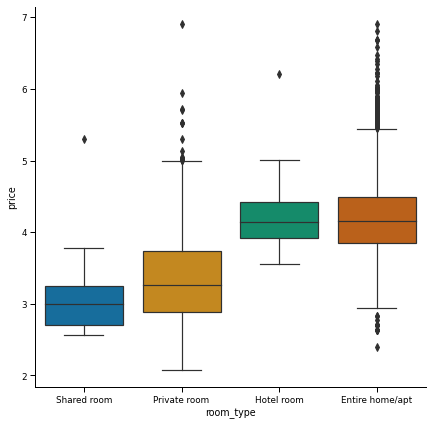

In [90]:
anova_room = pg.anova(airbnb_filtered, dv='price', between='room_type', detailed=True, effsize='np2')
kruskal_room = pg.kruskal(airbnb_filtered, dv='price', between='room_type', detailed=True)

t_tests = multiple_comparisons(airbnb_filtered, room_list, 'room_type', 'price')
significant_comparisons = t_tests[t_tests['p-val'] <= .05].round(2).sort_values(by=['X', 'T'], ascending=True)

display(anova_room.round(3), kruskal_room.round(3), significant_comparisons)

fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(x='room_type', y='price', data=airbnb_filtered.sort_values(by=['room_type', 'price'], ascending=False), 
            palette='colorblind')
sns.despine()

### Differences in mean price per accomodation size

As expected, there are significant differences in mean price depending on accomodation size. We can see in T-test comparisons that large accomodations are more expensive than medium and small, and also medium sizes are more expensive than small accomodations.

Performing t-test for comparison: small and medium
Performing t-test for comparison: small and large
Performing t-test for comparison: medium and large


,Source,SS,DF,MS,F,p-unc,np2
0,size,609.468,2,304.734,1068.784,0.0,0.289
1,Within,1502.024,5268,0.285,NaN,NaN,NaN


,Source,ddof1,H,p-unc
Kruskal,size,2,1435.012,0.0


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,X,Y
T-test,-21.39,465.43,two-sided,0.0,"[-0.74, -0.61]",1.37,3.768e+91,1.0,medium,large
T-test,-36.11,594.91,two-sided,0.0,"[-1.28, -1.15]",1.99,1.157e+220,1.0,small,large
T-test,-32.15,3040.05,two-sided,0.0,"[-0.57, -0.51]",1.02,4.629e+201,1.0,small,medium


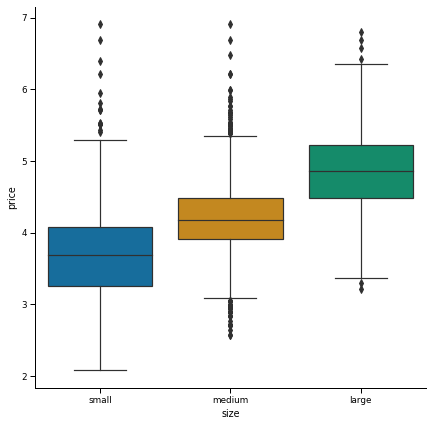

In [91]:
anova_size = pg.anova(airbnb_filtered, dv='price', between='size', detailed=True, effsize='np2')
kruskal_size = pg.kruskal(airbnb_filtered, dv='price', between='size', detailed=True)

t_tests = multiple_comparisons(airbnb_filtered, sizes_list, 'size', 'price')
significant_comparisons = t_tests[t_tests['p-val'] <= .05].round(2).sort_values(by=['X', 'T'], ascending=True)

display(anova_size.round(3), kruskal_size.round(3), significant_comparisons)

fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(x='size', y='price', data=airbnb_filtered, palette='colorblind')
sns.despine()

# TRABAJAR AQUÍ

We have selected categorical features performing Analysis of Variance for each variable. Now, I am curious about Sklearn methods.

In [ ]:
# Import mutual_info_classif from Scikit-learn
from sklearn.feature_selection import mutual_info_classif

# Create mutual_info_classif object to calculate mutual information
MI_score = mutual_info_classif(X_data, y_data, random_state=0)

# Print the name and mutual information score of each feature
for feature in zip(feature_names, MI_score):
    print(feature)

# Dummy coding of categorical variables

Let's recode the categorical variables and transform them into dummy variables to introduce them in regression. We will also remove the first column as it is not neccesary.

In [44]:
X_dummies = pd.get_dummies(X[categorical_cols], drop_first=True)
display(X_dummies)

KeyError: "['property_type'] not in index"

# Feature selection of continuous variables and model build

## Normalize training data (continuous variables)

To avoid that different scales could affect model fitting, we will normalize the scores using z-scores, to each variables will be ranged between 0 and 1.

In [45]:
from sklearn.preprocessing import StandardScaler

### Association between continuous variables

I always have love to see the correlation tables in a triangle shape, I have found this code in Bibor Szabo in Medium. Thank you so much for merging this type of tables with heatmaps!

We can see that the higher the number of persons a host can accomodates, number of bedrooms and beds, the higher the price. However, we don't find any correlation of price with longitude and latitude, interesting... I was expecting to find and association at least with latitude. Maybe we don't have much variability in the latitude...

This result could also be important for feature selection. Maybe we are going to see a high multicollinearity between 'accomodates' and 'beds' or 'bedrooms', so it could be good to keep only one of these features (i.e. 'accomodates'). Dropping these variables we are not going to lose much information, as it is already provided by 'accomodates'. Anyway, we will explore multicollinearity too in further steps.

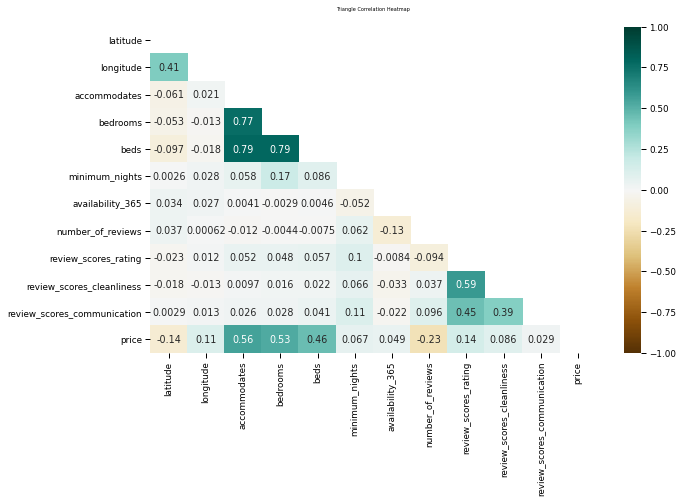

In [71]:
np.triu(np.ones_like(airbnb_filtered[numeric_variables].corr(method='spearman')))
plt.figure(figsize=(10, 6))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(airbnb_filtered[numeric_variables].corr(method='spearman'), dtype=np.bool))
heatmap = sns.heatmap(airbnb_filtered[numeric_variables].corr(method='spearman'), mask=mask, vmin=-1, vmax=1, annot=True, 
                      cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':5}, pad=16);

# Regression


Based on Analysis of Variance, we have decided to keep 'neighbourhood', 'room type' and 'accomodation size' as they are significantly correlated with our target variable 'price'. However, we still have quite a few continuous and ordinal variables, and we should perform some Feature Selection to decide which features are important contributors to predict 'price.


Hacer regression lineal primero con variables continuas. Interesante hacer Regression Cuantil.


Hacer regression Lasso para quedarse con los predictores más importantes


Usar GridSeachCV para buscar los predictores más importantes


Hacer Ridge Regression

## Steps

1. **Dummy coding**
1. **Impute missing** data in the DataFrame.
2. **Train-test split**: feature selection is a process of training, so we will select features only on the training set.
3. **Scale data**: we are going to scale all data to avoid differences in scales of features to influence model fitting.
4. **Feature selection**: embedded methods [they integrate a feature selection step as a part of the training process (i.e., feature selection and training process are performed simultaneously)]
5. **Model build**

So far we have selected neighbourhood, room type and size as predictors based on Analysis of Variance.

In [94]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

## Assess multicollinearity

Now that we have created our dummy variables, let's assess multicolinerity. For this, we will use VIF value. If the VIF values lies between 0 and 10, we should not consider multicollinearity in our data. However, if this value is less than 1 or greater than 10, we should considered it.

In [151]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif

We can see that we have a high multicollinearity between latitude and longitude, as we as with accomodates, bedrooms and beds. But also there is a strong multicollinearoty in Centro neighourhood!

Let's asses multicollinearity also with eigenvalues.

In [152]:
compute_vif(airbnb_dummies).sort_values(by='VIF', ascending=False)

,variables,VIF
0,latitude,224064.069203
1,longitude,221771.636006
8,review_scores_rating,312.772494
6,review_scores_communication,298.705396
7,review_scores_cleanliness,241.246673
11,price,80.882485
2,accommodates,35.201845
14,neighbourhood_cleansed_Centro,30.355071
26,size_small,22.770996
25,size_medium,22.379893


In [154]:
def compute_multicollinearity_corr(X, corr_method):
    
    corr=X.corr(method=corr_method)
    
    # Calculating VIF
    mc_corr = pd.DataFrame()
    mc_corr['variables'] = X.columns
    multicollinearity, V=np.linalg.eig(corr)
    mc_corr['eigenvalues'] = [multicollinearity[i] for i in range(X.shape[1])]

    return mc_corr

We have two values close to zero, which are beds and minimum_nights. As both variables are correlated with bedrooms, in the case of beds this correlation is stronger. We will drop bedrooms and we will check again for multicollinearity afterwards.

In [155]:
compute_multicollinearity_corr(airbnb_dummies, 'pearson').sort_values(by='eigenvalues', ascending=True)

,variables,eigenvalues
5,number_of_reviews,0.035009
6,review_scores_communication,0.036176
7,review_scores_cleanliness,0.077346
8,review_scores_rating,0.152580
9,bedrooms,0.207348
10,beds,0.233563
11,price,0.291839
12,neighbourhood_cleansed_Campanillas,0.399067
13,neighbourhood_cleansed_Carretera de Cadiz,0.543765
14,neighbourhood_cleansed_Centro,0.643076


Although we keep dropping columns and computing eigenvalues, there are always values close to zero (approximately 0.03 and 0.07). We will drop those values that we think are redundant based on the information that we already have in the DataFrame, and trust the regularization term (lambda) of Lasso regression. This type of regression will also help us to choose the most important predictors for price.

In [50]:
airbnb_malaga_X_ = airbnb_malaga_X.drop(columns=['bedrooms'])
compute_multicollinearity_corr(airbnb_malaga_X_, 'pearson').sort_values(by='eigenvalues', ascending=True)

,variables,eigenvalues
4,minimum_nights,0.035481
5,availability_365,0.078294
6,number_of_reviews,0.147938
7,review_scores_rating,0.209996
8,review_scores_cleanliness,0.292265
10,neighbourhood_cleansed_Campanillas,0.548398
11,neighbourhood_cleansed_Carretera de Cadiz,0.704805
14,neighbourhood_cleansed_Ciudad Jardin,0.904027
15,neighbourhood_cleansed_Cruz De Humilladero,0.920061
16,neighbourhood_cleansed_Este,0.949870


Let's initiate the regression object. As we want to increase the generalization of the model, we will set a low alpha value. As we increase the alpha value, the generalization becomes lower setting more restrictions to the coefficients.

In [55]:
lasso = Lasso()

Before entering the data into the regression model, we should transform the data into numpy arrays and reshape y to make it 2D.

In [56]:
np_y = np.array(airbnb_malaga_y).reshape(-1, 1)
np_X = airbnb_malaga_X.to_numpy()

print(np_y.shape, np_X.shape)

(5289, 1) (5289, 24)


Let's create a Pipeline to perform regression analysis and also let's split the data in train a test set in a 80/20 proportion.

In [58]:
steps = [('scaler', scaler), ('lasso_regression', Lasso)]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(np_X, np_y, test_size=0.2, random_state=42)

We are going to perform GridSearch for hyperparameter tuning, we will also use a 5-fold cross-validation.

In [59]:
cv = 5
param_grid = {'alpha': np.array([1, 0.1, 0.01, 0.001, 0.0001, 0]), 
              'normalize': ([True, False])}

lasso_cv = GridSearchCV(estimator=lasso, 
                        param_grid=param_grid, 
                        cv=cv,
                        scoring='neg_mean_squared_error')

In [60]:
lasso_cv.fit(X_train, y_train)
lasso_best_params = lasso_cv.best_params_
lasso_best_score = lasso_cv.best_score_
print('Best parameters for Lasso Regression: ' + str(lasso_best_params) + '\n' + 'Best score for Lasso Regression: ' + str(lasso_best_score))

C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362.82136671552064, tolerance: 0.13775672753682638
  positive)
C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\seba

Best parameters for Lasso Regression: {'alpha': 0.0, 'normalize': True}
Best score for Lasso Regression: -0.2139261602065542


C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355.69449523528755, tolerance: 0.1342982136708786
  positive)
C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:715: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 443.3142597271938, tolerance: 0.16813348585499358
  positive)


In [63]:
lasso_model = Lasso(alpha=0, normalize=True)
lasso_model.fit(X_train, y_train)
lasso_coef = lasso_model.coef_
y_pred_train_lasso = lasso_model.predict(X_train)
y_pred_test_lasso = lasso_model.predict(X_test)

C:\Users\sebas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 443.3142597271938, tolerance: 0.16813348585499358
  positive)


As we have a coefficient for every predictor, let's plot those coefficients to detect the most important predictors in the model.

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


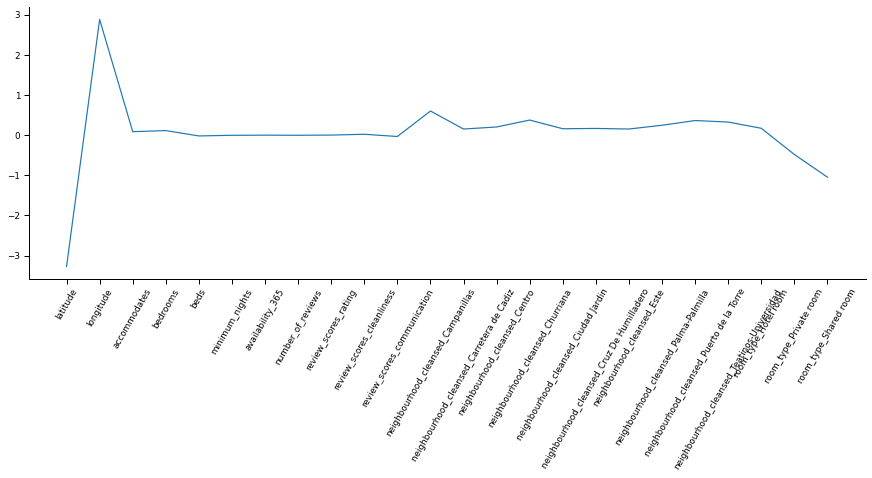

In [64]:
x_ticks = list(airbnb_malaga_X.columns)
fig, ax = plt.subplots(figsize=(15, 5))
sns.set_context('paper')
sns.lineplot(range(len(x_ticks)), lasso_coef)
plt.xticks(range(len(x_ticks)), x_ticks, rotation=60)
sns.despine()
plt.show()

Let's compute scores for both train and test data. We see that the model has very similar Score, Mean Squared Error and RMSE on both train and validation data.

In [69]:
# R squared
lasso_score = lasso_model.score(X_test, y_test)
lasso_score_train = lasso_model.score(X_train, y_train)
# MSE
mse = mean_squared_error(y_test, y_pred_test_lasso)
mse_train = mean_squared_error(y_train, y_pred_train_lasso)
# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_lasso))
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_lasso))

print('Lasso score on test data: ' + str(lasso_score) + '\n' + 'Mean Squared Error on test data: ' + str(mse) + '\n' + 'Mean Squared Error (squared root) on test data: ' + str(rmse))
print('\n')
print('Lasso score on train data: ' + str(lasso_score_train) + '\n' + 'Mean Squared Error on test data: ' + str(mse_train) + '\n' + 'Mean Squared Error (squared root) on train data: ' + str(rmse_train))

Lasso score on test data: 0.4798747687260957
Mean Squared Error on test data: 0.21146685042112712
Mean Squared Error (squared root) on test data: 0.45985524942217104


Lasso score on train data: 0.472663928339023
Mean Squared Error on test data: 0.2095553106722732
Mean Squared Error (squared root) on train data: 0.4577721165299097


Lasso regularization for feature selection (embedded method). In this case, if the feature is irrelevant, Lasso regularization will penalize it making it zero, then we will not consider all those features labelled as zero.

In [70]:
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(np_X, np_y)
print("Best alpha using built-in LassoCV: %f" %reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(np_X, np_y))
coef = pd.Series(reg.coef_, index = airbnb_malaga_X.columns)

Best alpha using built-in LassoCV: 0.008156
Best score using built-in LassoCV: 0.453405


C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [71]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 11 variables and eliminated the other 13 variables


We can see in the graph that Lasso took as important features:

* bedrooms
* accommodates
* neighbourhood_cleansed_Este
* review_scores_rating
* number of reviews
* minimum_nights
* review_scores_communication
* beds
* room_type_Private_room

Text(0.5, 1.0, 'Feature importance using Lasso Model')

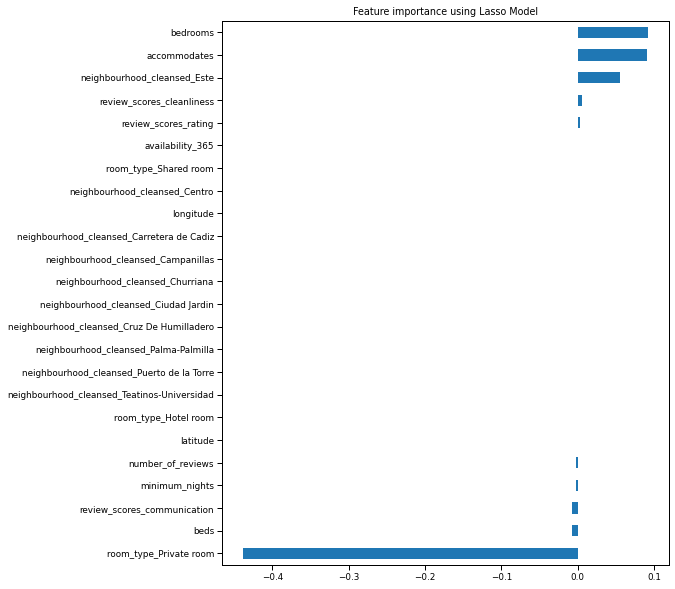

In [72]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

RFR

In [85]:
from sklearn.ensemble import  RandomForestRegressor
# create an object of the RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=10)

# fit the model with the training data
model_RFR.fit(X_train, y_train)

# predict the target on train and test data
predict_train = model_RFR.predict(X_train)
predict_test = model_RFR.predict(X_test)

# Root Mean Squared Error on train and test data
print('RMSE on train data: ', mean_squared_error(y_train, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(y_test, predict_test)**(0.5))

RMSE on train data:  0.31094232303185393
RMSE on test data:  0.43706100375430085


C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\sebas\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


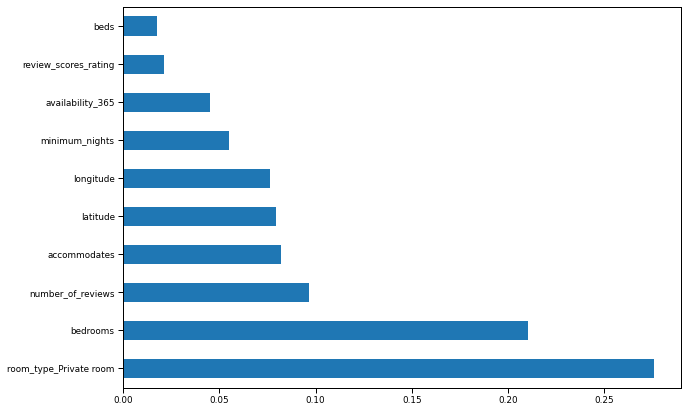

In [88]:
# plot the 7 most important features 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFR.feature_importances_, index = airbnb_malaga_X.columns)
feat_importances.nlargest(10).plot(kind='barh');

In [94]:
from sklearn.feature_selection import RFE

# Feature extraction
model = Lasso()
rfe = RFE(model, 10)
fit = rfe.fit(np_X, np_y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
print(airbnb_malaga_X.columns[fit.support_])

Num Features: 10
Selected Features: [False False False False False False  True  True False False False False
 False False False False  True  True  True  True  True  True  True  True]
Feature Ranking: [15 14 13 12 11 10  1  1  7  6  5  4  3  2  9  8  1  1  1  1  1  1  1  1]
Index(['availability_365', 'number_of_reviews',
       'neighbourhood_cleansed_Cruz De Humilladero',
       'neighbourhood_cleansed_Este', 'neighbourhood_cleansed_Palma-Palmilla',
       'neighbourhood_cleansed_Puerto de la Torre',
       'neighbourhood_cleansed_Teatinos-Universidad', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')


C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(kepler_X, kepler_y)

pd.Series(clf.feature_importances_, index=kepler.columns[1:]).plot.bar(color='steelblue', figsize=(12, 6))

# USE THE VALIDATION SET FOR HYPERPARAMETER TUNING
Summarize findings here